script for identifying text to generate dataset

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

from ultralytics import utils
import torch
import torch.nn as nn 
import cv2  # For image loading
from ultralytics import Drone, FastSAM, YOLO #or from your project import Drone
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
import pandas as pd
from PIL import Image, ImageDraw, ImageFont


Using GPU: Quadro P3200


In [ ]:
model = YOLO("yolo11s-seg.pt", verbose=False)
first_run = True

In [16]:
features = []
def hook_function(module, input, output):
    print("Output shape" ,output.shape)
    global first_run
    if first_run == True:
        first_run = False
    else:
      features.append(output)

hook_handle = model.model.model[16].register_forward_hook(hook_function)


In [7]:
output = model("test1.jpg")  # Replace with your image path

len(features)


Call Stack:
Function: forward, File: d:\ml\ultralytics\ultralytics\nn\modules\block.py, Line: 94
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: forward, File: d:\ml\ultralytics\ultralytics\nn\modules\head.py, Line: 191
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: _predict_once, File: d:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 151
Function: predict, File: d:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 130
Function: forward, File: d:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 112
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\m

NameError: name 'features' is not defined

In [4]:
import os

class SequencePathGenerator:
    def __init__(self, base_path, sequence_folder_path):
        self.base_path = base_path
        self.sequence_folder_path = sequence_folder_path
        self.subfolders = sorted([
            item for item in os.listdir(sequence_folder_path)
            if os.path.isdir(os.path.join(sequence_folder_path, item))
        ])
        self.current_index = 0

    def get_next(self):
        if not self.subfolders:
            return None, None, None

        if self.current_index >= len(self.subfolders):
            return None, None, None

        subfolder_name = self.subfolders[self.current_index]
        subfolder_path = os.path.join(self.sequence_folder_path, subfolder_name)

        sequence_path = os.path.join(self.base_path, os.path.relpath(subfolder_path, self.base_path))
        csv_path = os.path.join(self.base_path, "all_csv", os.path.relpath(subfolder_path, self.base_path))

        print(f"Folder: {subfolder_name}")
        print(f"Sequence Path: {sequence_path}")
        print(f"CSV Path: {csv_path}")
        print("-" * 20)

        self.current_index += 1
        return subfolder_name, sequence_path, csv_path

    def get_previous(self):
        if not self.subfolders:
            return None, None, None

        if self.current_index <= 1:
            return None, None, None

        self.current_index -= 2  # Move back two, as get_next advances by one.
        return self.get_next() #reuse get_next to provide the output.

# Example usage:
base_path = r"E:\Dataset"
sequence_folder_path = os.path.join(base_path, "VisDrone2019-MOT-test-dev", "sequences")

generator = SequencePathGenerator(base_path, sequence_folder_path)

In [59]:
import cv2
import os

def display_sequence_as_video(sequence_path, resize_width=None, resize_height=None, frame_delay=30):
    """
    Displays frames from a sequence folder as a video, exiting only on 'q' press.

    Args:
        sequence_path (str): Path to the folder containing the sequence of JPG images.
        resize_width (int, optional): Target width for resizing. If None, no resizing.
        resize_height (int, optional): Target height for resizing. If None, no resizing.
        frame_delay (int): Delay in milliseconds between frames.
    """

    frame_files = sorted([f for f in os.listdir(sequence_path) if f.lower().endswith(".jpg")])
    if not frame_files:
        print("No JPG images found in the specified folder.")
        return

    for frame_file in frame_files:
        frame_path = os.path.join(sequence_path, frame_file)

        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Error: Could not read image {frame_path}")
            continue

        if resize_width is not None and resize_height is not None:
            frame = cv2.resize(frame, (resize_width, resize_height))

        cv2.putText(frame, frame_file, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Sequence Video", frame)

        key = cv2.waitKey(frame_delay)

        if key == ord("q"):
            break

    cv2.destroyAllWindows()

# Example usage:
name, sequence_path, csv_path = generator.get_next()
display_sequence_as_video(sequence_path, resize_width=640, resize_height=480, frame_delay=3)

Folder: uav0000249_00001_v
Sequence Path: E:\Dataset\VisDrone2019-MOT-test-dev\sequences\uav0000249_00001_v
CSV Path: E:\Dataset\all_csv\VisDrone2019-MOT-test-dev\sequences\uav0000249_00001_v
--------------------


In [577]:
def display_sequence_frames(sequence_path):
    """
    Displays frames from a sequence folder, allowing navigation with 'a' and 'd' keys.

    Args:
        sequence_path (str): Path to the folder containing the sequence of JPG images.
    """
    resize_width = 640
    resize_height = 480
    frame_files = sorted([f for f in os.listdir(sequence_path) if f.lower().endswith(".jpg")])
    if not frame_files:
        print("No JPG images found in the specified folder.")
        return

    frame_index = 0
    while True:
        frame_file = frame_files[frame_index]
        frame_path = os.path.join(sequence_path, frame_file)

        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Error: Could not read image {frame_path}")
            break

        if resize_width is not None and resize_height is not None:
            frame = cv2.resize(frame, (resize_width, resize_height))

        cv2.putText(frame, frame_file, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.imshow("Sequence Frame", frame)

        key = cv2.waitKey(1) & 0xFF  # Use waitKey(1) to allow for continuous key presses

        if key == ord("d"):
            frame_index = min(frame_index + 1, len(frame_files) - 1)
        elif key == ord("a"):
            frame_index = max(frame_index - 1, 0)
        elif key == ord("q"):  # Press 'q' to quit
            break

    cv2.destroyAllWindows()

# Example usage:
#sequence_path = "E:\Dataset\VisDrone2019-MOT-test-dev\sequences/uav0000073_00600_v"  # Replace with your sequence folder path
display_sequence_frames(sequence_path)

In [ ]:
#model = YOLO("yolo11s-seg.pt")
#model.eval()
if device == 'cuda':
    model = model.to(device)

image_path = f"{sequence_path}/0000001.jpg"
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((480, 640)),  # Resize the image
    transforms.ToTensor(),          # Convert to tensor
   ])

# Apply the transformations
image_tensor = transform(image).unsqueeze(0).to(device) #add batch dimension and send to device

with torch.no_grad():
    results = model(image_tensor)

image = results[0].orig_img
bboxes = results[0].pred[:, :6]
draw_bboxes(image, bboxes)

In [19]:
#model = YOLO("yolo11s-seg.pt")
#model.eval()
if device == 'cuda':
    model = model.to(device)

image = Image.open("test1.jpg").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((480, 640)),  # Resize the image
    transforms.ToTensor(),          # Convert to tensor
   ])

# Apply the transformations
image_tensor = transform(image).unsqueeze(0).to(device) #add batch dimension and send to device

with torch.no_grad():
    results = model(image_tensor)



Output shape torch.Size([1, 128, 60, 80])
Call Stack:
Function: forward, File: d:\ml\ultralytics\ultralytics\nn\modules\block.py, Line: 94
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: forward, File: d:\ml\ultralytics\ultralytics\nn\modules\head.py, Line: 191
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: _predict_once, File: d:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 151
Function: predict, File: d:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 130
Function: forward, File: d:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 112
Function: _call_impl, File: d:\software\anacond

In [56]:
idx = 4

image = results[0].orig_img
bboxes = results[0].pred[idx, :6]
draw_bboxes(image, bboxes, cls = True)

mid_x = (results[0].scaled_preds[idx][0] + results[0].scaled_preds[idx][2]) / 2
mid_y = (results[0].scaled_preds[idx][1] + results[0].scaled_preds[idx][3]) / 2
xyxy_tensor = results[0].boxes.xyxy[idx,:6]
mid_x = mid_x.item()
mid_y = mid_y.item()
for i, val in enumerate(xyxy_tensor):
    if i == 0:
        print(f"  x1: {val}")
        x1 = val
    elif i == 1:
        print(f"  y1: {val}")
        y1 = val
    elif i == 2:
        print(f"  x2: {val}")
        x2 = val
    else:
        print(f"  y2: {val}")
        y2 = val

(640, 480)
  x1: 319.75128173828125
  y1: 207.61245727539062
  x2: 355.84423828125
  y2: 276.3339538574219


In [60]:
text = "Fly fast and go straight along the road"
class_val = 5  # Number int
label = "Truck"
row_index = 1    - 1  #Must minus with 1 because in pd index will be starting with 0 where frame 1 will be at index 0

In [61]:
mid_x = None
mid_y = None
x1 = None
y1 = None
x2 = None
y2 = None
class_val = None
label = None

In [62]:
def update_csv_with_yolo_data(sequence_path, row_index, mid_x, mid_y, x1, y1, x2, y2, text, class_val, label):
    """
    Updates a specified row of output.csv in the given sequence path with YOLO data.

    Args:
        sequence_path (str): The path to the sequence folder.
        row_index (int): The row index to update (0-based).
        mid_x (torch.Tensor or float or None): The x-coordinate of the midpoint.
        mid_y (torch.Tensor or float or None): The y-coordinate of the midpoint.
        x1 (torch.Tensor or float or None): The x1 coordinate of the bounding box.
        y1 (torch.Tensor or float or None): The y1 coordinate of the bounding box.
        x2 (torch.Tensor or float or None): The x2 coordinate of the bounding box.
        y2 (torch.Tensor or float or None): The y2 coordinate of the bounding box.
        text (str or None): The text to add.
        class_val (int or None): The class value.
        label (str or None): The label.
    """
    csv_path = os.path.join(sequence_path, "output.csv")

    try:
        df = pd.read_csv(csv_path)

        if len(df) <= row_index:
            print(f"Warning: {csv_path} does not have enough rows to update row {row_index}.")
            return

        df.loc[row_index, "x_cord"] = mid_x.item() if isinstance(mid_x, torch.Tensor) else mid_x if mid_x is not None else np.nan
        df.loc[row_index, "y_cord"] = mid_y.item() if isinstance(mid_y, torch.Tensor) else mid_y if mid_y is not None else np.nan
        df.loc[row_index, "text"] = text if text is not None else np.nan
        df.loc[row_index, "x1"] = x1.item() if isinstance(x1, torch.Tensor) else x1 if x1 is not None else np.nan
        df.loc[row_index, "y1"] = y1.item() if isinstance(y1, torch.Tensor) else y1 if y1 is not None else np.nan
        df.loc[row_index, "x2"] = x2.item() if isinstance(x2, torch.Tensor) else x2 if x2 is not None else np.nan
        df.loc[row_index, "y2"] = y2.item() if isinstance(y2, torch.Tensor) else y2 if y2 is not None else np.nan
        df.loc[row_index, "class"] = class_val if class_val is not None else np.nan
        df.loc[row_index, "label"] = label if label is not None else np.nan

        df.to_csv(csv_path, index=False)
        print(f"Updated row {row_index} in {csv_path} with YOLO data.")

    except FileNotFoundError:
        print(f"Error: {csv_path} not found.")
    except Exception as e:
        print(f"Error processing {csv_path}: {e}")

# Example usage:
# sequence_path = "E:\Dataset\VisDrone2019-MOT-test-dev\sequences/uav0000073_04464_v"
# row_index = 2  # Update the third row (index 2)
# mid_x = 100.5
# mid_y = 200.2
# x1 = 50.0
# y1 = 100.0
# x2 = 150.0
# y2 = 300.0
# text = "object detected"
# class_val = 2
# label = "car"
update_csv_with_yolo_data(csv_path, row_index, mid_x, mid_y, x1, y1, x2, y2, text, class_val, label)
# update_csv_with_yolo_data(sequence_path, row_index, None, None, None, None, None, None, None, None, None) # this will add null values.
mid_x = None
mid_y = None
x1 = None
y1 = None
x2 = None
y2 = None

Updated row 0 in E:\Dataset\all_csv\VisDrone2019-MOT-test-dev\sequences\uav0000249_00001_v\output.csv with YOLO data.


In [3]:
def draw_bboxes(image, bboxes, font_size=12, display=True, cls = False):
    """
    Draw bounding boxes on an image with thin idx text above.
    Optionally displays the image in a new window.

    Args:
        image: Path to image, PIL Image, torch.Tensor (C, H, W) or (1, C, H, W), 
               or NumPy array (H, W, C) or (H,W).
        bboxes: List of bounding boxes [(x_min, y_min, x_max, y_max, conf, class_id)].
        font_size: Size of the text font.
        display (bool): If True, displays the image in a new window.

    Returns:
        PIL Image with drawn bounding boxes.
    """

    if isinstance(image, str):
        pil_image = Image.open(image).convert("RGB")
        print(pil_image.size)
    elif isinstance(image, torch.Tensor):
        if image.ndim == 4:
            image = image.squeeze(0)
        if image.is_cuda:
            image = image.cpu()
        image = image.permute(1, 2, 0)
        if image.dtype == torch.float:
            image_numpy = image.numpy()
        elif image.dtype == torch.uint8:
            image_numpy = image.numpy() / 255.0
        else:
            raise TypeError("Tensor dtype should be either torch.float or torch.uint8")
        pil_image = Image.fromarray((image_numpy * 255).astype(np.uint8))
        print(pil_image.size)
    elif isinstance(image, np.ndarray):
        if image.ndim == 2:
            pil_image = Image.fromarray(image)
            print(pil_image.size)
        elif image.ndim == 3:
            pil_image = Image.fromarray(image)
            print(pil_image.size)
        else:
            raise ValueError("Numpy array should have 2 or 3 dimensions")
    elif isinstance(image, Image.Image):
        pil_image = image
        print(pil_image.size)
    else:
        raise TypeError("Unsupported image type. Must be path, PIL Image, torch.Tensor, or NumPy array.")

    draw = ImageDraw.Draw(pil_image)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    if isinstance(bboxes, torch.Tensor):
        if bboxes.ndim == 1:
            bboxes = [bboxes.tolist()]
        else:
            bboxes = bboxes.tolist()

    for idx, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max, conf, class_id = map(int, bbox[:6])

        # Draw the rectangle
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=1)

        # Format text, positioned above the bounding box
        if cls:
            text = f'class {class_id}, IDX {idx}'
        else:
            text = f'{idx}'
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Position text above the box
        text_position = (x_min, y_min - text_height - 5)

        text_size = draw.textbbox(text_position, text, font=font)
        # remove the rectangle behind the text.
        for offset in [-1, 0, 1]:
            draw.text((text_position[0] + offset, text_position[1]), text, font=font, fill="white")
            draw.text((text_position[0], text_position[1] + offset), text, font=font, fill="white")

    if display:
        pil_image.show()

    #return pil_image

#image = results[0].orig_img
#bboxes = results[0].pred[25, :6]
#draw_bboxes(image, bboxes)

In [ ]:
img_shape = output[0].img.shape[2:]
print(img_shape)

original_img_shape = output[0].orig_img.shape[:2]
print(original_img_shape)
#output[0].pred[3, :4],
# 33.6954 74.1577
# 33.2715 76.4349

torch.Size([384, 640])
(756, 1344)


In [43]:
img_shape = results[0].img.shape[:]
print(img_shape)

original_img_shape = results[0].orig_img.shape[:]
print(original_img_shape)
#output[0].pred[3, :4], 

torch.Size([1, 3, 640, 640])
(640, 640, 3)


In [172]:
output[0].pred[4 , :6], output[0].scaled_preds[3, :6]

(tensor([6.6960e+02, 3.6135e+02, 6.9413e+02, 3.8466e+02, 6.1465e-01, 2.0000e+00], device='cuda:0'),
 tensor([30.8574, 70.9297, 36.5334, 77.3857], device='cuda:0'))

In [174]:
scaled_preds = utils.ops.scale_boxes(output[0].orig_img.shape[:2], output[0].pred[3, :6].clone(), (80, 80)) # (80, 80) is size of feature map from layer 16 for 640, 640 image
scaled_preds

tensor([30.2479, 72.9917, 36.3023, 79.8781,  0.6187,  2.0000], device='cuda:0')

In [90]:
import torch
import numpy as np
# Assuming results[0].boxes.data[3] is your tensor
point = output[0].boxes.data[17].clone()    #Data [4.3514835e+02 3.9504425e+02 4.5951508e+02 4.2142441e+02 1.5803802e-01 2.0000000e+00] --> [14.936334   41.803627   17.514824   44.595177    0.15803802  2.        ]  -->(16.22557830810547, 43.19940185546875)
if point.is_cuda:
    point = point.cpu()

# Convert to NumPy
point_np = point.numpy()

# Set NumPy print options to display full precision
np.set_printoptions(precision=10)  # Adjust precision as needed

# Print the NumPy array
print(point_np)
print(type(point_np))

#Reset print options
np.set_printoptions(precision=8)

[4.3514835e+02 3.9504425e+02 4.5951508e+02 4.2142441e+02 1.5803802e-01 2.0000000e+00]
<class 'numpy.ndarray'>


In [89]:
results[0].orig_shape

(640, 640)

In [ ]:
mid_x = (output[0].scaled_preds[17][0] + output[0].scaled_preds[17][2]) / 2
mid_y = (output[0].scaled_preds[17][1] + output[0].scaled_preds[17][3]) / 2

midpoint = (mid_x, mid_y)  # Store as a tuple

print(f"Midpoint: {midpoint}")  

tensor([16.5028, 41.6909, 18.9201, 44.3080], device='cuda:0')
Midpoint: (tensor(17.7115, device='cuda:0'), tensor(42.9994, device='cuda:0'))


In [37]:
feature_maps["sum_up"].shape

torch.Size([1, 128, 80, 80])

In [38]:
results[0].orig_shape

(640, 640)

In [39]:
sum_up = feature_maps['sum_up'][0]
sum_up.shape, sum_up.shape[1:]

(torch.Size([128, 80, 80]), torch.Size([80, 80]))

In [40]:
masks = results[0].masks.data
results[0].masks.data.shape

torch.Size([24, 640, 640])

In [41]:
img = results[0].img
#img = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
img.shape

torch.Size([1, 3, 640, 640])

In [87]:
masks = results[0].masks.data
masks.shape, type(masks)

(torch.Size([24, 640, 640]), torch.Tensor)

In [43]:
results[0].masks.data.shape

torch.Size([24, 640, 640])

In [15]:
results[0].boxes.xyxy.shape

torch.Size([20, 4])

In [44]:
proto = results[0].proto
pred = results[0].pred
proto.shape, pred.shape

(torch.Size([32, 160, 160]), torch.Size([24, 38]))

In [73]:
pred[:, :6], results[0].scaled_preds

(tensor([[2.4368e+02, 3.0364e+02, 2.5640e+02, 3.2363e+02, 6.0900e-01, 2.0000e+00],
         [2.6386e+02, 2.9811e+02, 2.7637e+02, 3.1838e+02, 5.8546e-01, 2.0000e+00],
         [3.3754e+01, 5.6730e+02, 8.8758e+01, 6.3967e+02, 5.5556e-01, 2.0000e+00],
         [1.0633e+02, 4.7173e+02, 1.3001e+02, 5.0383e+02, 4.9292e-01, 2.0000e+00],
         [3.3110e+02, 2.5696e+02, 3.3992e+02, 2.7446e+02, 4.8453e-01, 2.0000e+00],
         [3.2030e+02, 4.7253e+02, 3.4174e+02, 5.2287e+02, 4.7803e-01, 2.0000e+00],
         [3.4310e+02, 2.6044e+02, 3.5121e+02, 2.7362e+02, 4.7038e-01, 2.0000e+00],
         [2.8453e+02, 2.6004e+02, 2.9661e+02, 2.7674e+02, 4.0595e-01, 2.0000e+00],
         [1.6272e+02, 5.1389e+02, 1.9013e+02, 5.7356e+02, 3.7553e-01, 2.0000e+00],
         [3.1914e+02, 3.0681e+02, 3.3061e+02, 3.2569e+02, 3.5215e-01, 2.0000e+00],
         [2.9099e+02, 2.3730e+02, 2.9907e+02, 2.5190e+02, 3.2624e-01, 2.0000e+00],
         [2.4817e+02, 3.3639e+02, 2.6454e+02, 3.6320e+02, 2.8891e-01, 2.0000e+00],
    

In [46]:
sum_up.shape[1:], img.shape[2:]

(torch.Size([80, 80]), torch.Size([640, 640]))

In [47]:
masks.shape

torch.Size([24, 640, 640])

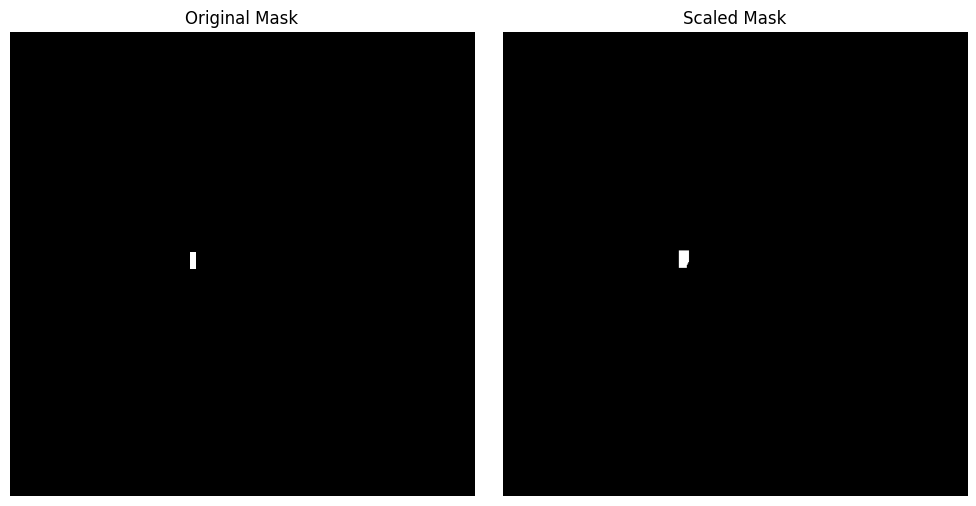

In [88]:
import torch.nn.functional as F

mask_np = masks.cpu().numpy()
mask_tensor = torch.tensor(mask_np)
short = F.interpolate(masks.unsqueeze(1), size=(80, 80), mode="nearest").squeeze(1)
short = short.cpu().numpy()


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

if short.ndim == 3:
    short = short[0]  # Remove the first dimension
if mask_np.ndim == 3:
    mask_np = mask_np[0]  # Remove the first dimension

# Plot the original and scaled masks
#fig, ax = plt.subplots(1, 2, figsize=(10, 5))
 # Original mask
ax[0].imshow(short, cmap="gray")
ax[0].set_title("Original Mask")
ax[0].axis("off")

# Scaled mask
ax[1].imshow(mask_np, cmap="gray")
ax[1].set_title("Scaled Mask")
ax[1].axis("off")

plt.tight_layout()
plt.show()

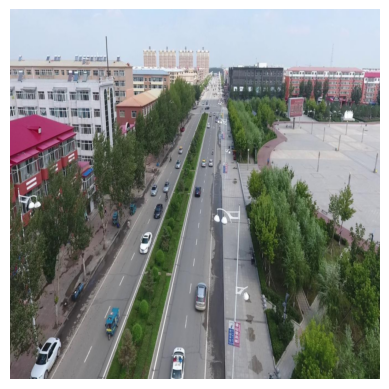

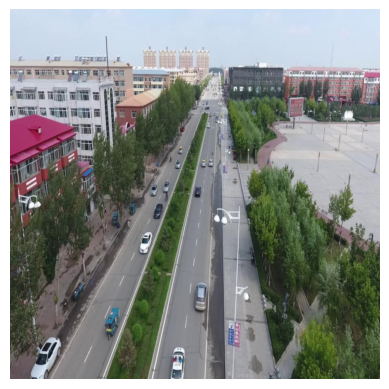

In [50]:
import torch
import torch
import matplotlib.pyplot as plt
import numpy as np

def show_image(image):
    """Displays either a PyTorch tensor or a NumPy array representing an image.

    Args:
        image: Either a PyTorch tensor (C, H, W) or (1, C, H, W) or a NumPy array (H, W, C) or (H, W). Values should be between 0 and 1 (for floats) or 0 and 255 (for uint8).
    """

    if isinstance(image, torch.Tensor):  # Check if it's a PyTorch tensor
        # 1. Check and remove batch dimension if present
        if image.ndim == 4:  # If it has a batch dimension (1, C, H, W)
            image = image.squeeze(0)  # Remove the batch dimension

        # 2. Check for CUDA tensor and move to CPU if needed
        if image.is_cuda:
            image = image.cpu()

        # 3. Permute the dimensions to (H, W, C) for Matplotlib
        image = image.permute(1, 2, 0)

        # 4. If the tensor is float, it's assumed to be in the range [0, 1].  If it's int, it's assumed to be in [0, 255]
        if image.dtype == torch.float:
            image_numpy = image.numpy()
        elif image.dtype == torch.uint8:  # Check if it is in uint8
            image_numpy = image.numpy() / 255.0  # Normalize if it is in uint8
        else:
            raise TypeError("Tensor dtype should be either torch.float or torch.uint8")


    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        if image.ndim == 2:  # Grayscale image (H, W)
          image_numpy = image
        elif image.ndim == 3:  # Color image (H, W, C)
          image_numpy = image
        else:
          raise ValueError("Numpy array should have 2 or 3 dimensions")

    else:
        raise TypeError("Input should be a PyTorch tensor or a NumPy array.")

    # 5. Display the image
    plt.imshow(image_numpy)
    plt.axis('off')  # Hide axes
    plt.show()

show_image(results[0].img)
show_image(results[0].orig_img)

In [51]:
masks = results[0].masks.data
scaled_preds = results[0].scaled_preds

scaled_preds.shape, masks.shape   # BBoxes,  MAsks


(torch.Size([24, 4]), torch.Size([24, 640, 640]))

In [23]:
def visualize_cropped_regions(features, masks, scaled_bboxes, processed_regions):
    """
    Visualize the cropped regions of masks and features.

    Args:
        features (torch.Tensor): Original feature tensor of shape [1, C, H_f, W_f].
        masks (torch.Tensor): Binary masks tensor of shape [N, H_m, W_m].
        scaled_bboxes (torch.Tensor): Bounding boxes tensor of shape [N, 4] (x_min, y_min, x_max, y_max).
        processed_regions (list): List of processed regions from `process_features_masks_bbs`.
    """
    _, C, H_f, W_f = features.shape

    for region in processed_regions:
        mask_idx, channel_idx, masked_features = region

        if channel_idx is None:
            print(f"Mask {mask_idx}: Cropped region is too small, skipping visualization.")
            continue

        # Original bounding box
        x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()

        # Visualize cropped mask
        cropped_mask = masks[mask_idx, int(y_min):int(y_max), int(x_min):int(x_max)].cpu().numpy()

        # Visualize cropped feature map (single channel)
        cropped_feature = masked_features.cpu().numpy()

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        # Cropped mask visualization
        ax[0].imshow(cropped_mask, cmap="gray")
        ax[0].set_title(f"Mask {mask_idx} - Cropped Region")
        ax[0].axis("off")

        # Cropped feature visualization (for the specified channel)
        ax[1].imshow(cropped_feature, cmap="viridis")
        ax[1].set_title(f"Channel {channel_idx} - Masked Features")
        ax[1].axis("off")

        plt.tight_layout()
        plt.show()

In [24]:
def draw_bboxes(image, bboxes, similarity_score = None, font_size=20):
    """
    Draw bounding boxes on an image (accepts image path, PIL Image, 
    torch.Tensor, or NumPy array).

    Args:
        image: Path to image, PIL Image, torch.Tensor (C, H, W) or (1, C, H, W), 
               or NumPy array (H, W, C) or (H,W).
        bboxes: List of bounding boxes [(x_min, y_min, x_max, y_max, conf, class_id)].
        font_size: Size of the text font.

    Returns:
        PIL Image with drawn bounding boxes.
    """
    
    if isinstance(image, str):  # If it's a path
        pil_image = Image.open(image).convert("RGB")  # Open and convert to RGB
    elif isinstance(image, torch.Tensor):
        # Convert torch.Tensor to PIL Image
        if image.ndim == 4:  # If it has a batch dimension (1, C, H, W)
            image = image.squeeze(0)  # Remove the batch dimension

        if image.is_cuda:
            image = image.cpu()

        image = image.permute(1, 2, 0)  # Change to HWC

        if image.dtype == torch.float:
            image_numpy = image.numpy()
        elif image.dtype == torch.uint8:
            image_numpy = image.numpy() / 255.0
        else:
            raise TypeError("Tensor dtype should be either torch.float or torch.uint8")

        pil_image = Image.fromarray((image_numpy * 255).astype(np.uint8))  # Scale to 0-255 and convert to uint8

    elif isinstance(image, np.ndarray):
        if image.ndim == 2:  # Grayscale image (H, W)
            pil_image = Image.fromarray(image)
        elif image.ndim == 3:  # Color image (H, W, C)
            pil_image = Image.fromarray(image)
        else:
            raise ValueError("Numpy array should have 2 or 3 dimensions")
    elif isinstance(image, Image.Image):  # Check if it's already a PIL Image
        pil_image = image
    else:
        raise TypeError("Unsupported image type. Must be path, PIL Image, torch.Tensor, or NumPy array.")


    draw = ImageDraw.Draw(pil_image)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    if isinstance(bboxes, list):  # If it's not already a list, make it one
        bboxes = [bboxes]

    if isinstance(bboxes, torch.Tensor):
        if bboxes.ndim == 1:  # If it's a single bounding box, wrap it in a list
            bboxes = [bboxes.tolist()]
        else:
            bboxes = bboxes.tolist()
    
    for idx, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max, conf, class_id = map(int, bbox[:6])
        
        if similarity_score is None:
            similarity_score = conf
            color = "green"
        else:
            color = "red"
        draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=3)

        # Format text
        text = f'id {idx}: {similarity_score}'
        text_position = (x_min, max(0, y_min - font_size - 5))

        text_size = draw.textbbox(text_position, text, font=font)  # Get text size
        draw.rectangle(text_size, fill="black")  # Background rectangle

        for offset in [-1, 0, 1]:
            draw.text((text_position[0] + offset, text_position[1]), text, font=font, fill="white")
            draw.text((text_position[0], text_position[1] + offset), text, font=font, fill="white")

    return pil_image

In [52]:
point = np.array([2.7762e+02, 5.8391e+02, 3.0320e+02, 6.3961e+02])
image_size = [640, 640]
scaled_preds = utils.ops.scale_boxes(image_size, point, (80, 80)) # (80, 80) is size of feature map from layer 16
print(scaled_preds)

mid_x = (scaled_preds[0] + scaled_preds[2]) / 2
mid_y = (scaled_preds[1] + scaled_preds[3]) / 2

midpoint = (mid_x, mid_y)  # Store as a tuple

print(f"Midpoint: {midpoint}")

[34.7025  72.98875 37.9     79.95125]
Midpoint: (36.301249999999996, 76.47)


Original

In [41]:
import torch
import torch.nn.functional as F
import torch.nn as nn
#ORIGINAL
class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.target_size = target_size
        self.out_channels = out_channels
        
    def forward(self, features, masks, scaled_bboxes, reference_mask=None):
        _, C, H_f, W_f = features.shape  # Features dimensions
        N, H_m, W_m = masks.shape       # Masks dimensions
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=features.device)

        if scaled_bboxes.shape[0] != N:
            raise ValueError(f"Number of bounding boxes ({scaled_bboxes.shape[0]}) does not match the number of masks ({N}).")

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  # Skip invalid bounding boxes
            
            cropped_features = features[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[int(y_min):int(y_max), int(x_min):int(x_max)]
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        # Reduce channels from [N, C, 16, 16] → [N, out_channels, 16, 16]
        processed_reduced = self.reduce_channels(processed_regions)

        if reference_mask is not None:
            self.reference_mask = reference_mask
        if self.reference_mask is None:
            self.reference_mask = processed_reduced[3]

        processed_flattened = processed_reduced.view(N, -1)  # [N, out_channels*16*16]
        reference_flattened = self.reference_mask.flatten().unsqueeze(0)  # [1, out_channels*16*16]
        similarity = F.cosine_similarity(processed_flattened, reference_flattened, dim=1)
        most_similar_idx = torch.argmax(similarity).item()
        similarity_score = similarity[most_similar_idx].item()  # Get the similarity score
        
        if similarity_score >= 0.1:  # Check if similarity is at least 50%
            self.reference_mask = processed_reduced[most_similar_idx]
        
        return {"bboxes":processed_reduced[most_similar_idx], "most_similar_idx":most_similar_idx, "similarity_score":similarity_score}

    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)  # Flatten H and W dimensions to create a 1D "sequence" for each channel. Shape: [N, C, H*W]
        x = self.conv1d(x)  # Apply the 1D convolution. Shape: [N, out_channels, H*W]
        x = x.view(N, self.out_channels, H, W)  # Reshape back to [N, out_channels, H, W]
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

##Example Usage
#features = feature_maps["sum_up"]  # [1, 128, H_f, W_f]
#maskss = masks  # Binary masks [N, H_m, W_m]
#bboxes = scaled_preds  # [N, 4]
#reference_mask = torch.randn(32, 16, 16, device=features.device)  # Shape [128, 16, 16]
#
## Process and find the most similar mask
#most_similar_mask, most_similar_idx, similarity_score = processor(features, maskss, bboxes, reference_mask)
#
#print(f"processed_reduced : {most_similar_idx}")

Kalman Filter + cosine similarity weitage

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
#OPENAI 1
class KalmanBoxTracker:
    def __init__(self, bbox):
        """
        Initialize a Kalman filter to track the bounding box [x_min, y_min, x_max, y_max].
        """
        self.kf = KalmanFilter(dim_x=8, dim_z=4)  # 8 states (position + velocity), 4 measurements (bbox)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],   # Transition matrix
                              [0, 1, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 1, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 1, 0, 0, 0, 1],   
                              [0, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 0, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 0, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)  # Observation matrix (bbox directly observed)
        self.kf.R *= 10  # Measurement noise
        self.kf.P *= 100  # Initial uncertainty
        self.kf.Q *= 0.01  # Process noise
        
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)  # Initialize state with bbox
        self.age = 0
    
    def predict(self):
        """
        Predict the next bounding box position.
        """
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()  # Return predicted bbox

    def update(self, bbox):
        """
        Update the Kalman Filter with the detected bounding box.
        """
        self.kf.update(np.array(bbox).reshape(4, 1))

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None  # Initialize tracker later
        
    def forward(self, features, masks, scaled_bboxes, reference_mask=None):
        _, C, H_f, W_f = features.shape  
        N, H_m, W_m = masks.shape
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=features.device)

        if scaled_bboxes.shape[0] != N:
            raise ValueError(f"Number of bounding boxes ({scaled_bboxes.shape[0]}) does not match the number of masks ({N}).")

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  # Skip invalid bounding boxes
            
            cropped_features = features[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[int(y_min):int(y_max), int(x_min):int(x_max)]
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat


        processed_reduced = self.reduce_channels(processed_regions)

        if reference_mask is not None:
            self.reference_mask = reference_mask
        if self.reference_mask is None:
            self.reference_mask = processed_reduced[3]  

        processed_flattened = processed_reduced.view(N, -1)  
        reference_flattened = self.reference_mask.flatten().unsqueeze(0)  

        cosine_sim = F.cosine_similarity(processed_flattened, reference_flattened, dim=1)

        # Initialize or update Kalman filter
        if self.tracker is None:
            self.tracker = KalmanBoxTracker(scaled_bboxes[3].tolist())
        predicted_bbox = torch.tensor(self.tracker.predict(), device=features.device)  # Predict next position

        # Compute distance between predicted bbox and each detected bbox
        centroids = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        predicted_centroid = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        euclidean_dist = torch.norm(centroids - predicted_centroid, dim=1)
        normalized_dist = euclidean_dist / euclidean_dist.max()

        # Compute weighted similarity
        alpha = 0.3  #increase for similarity  
        weighted_similarity = (alpha * cosine_sim) - ((1 - alpha) * normalized_dist)

        most_similar_idx = torch.argmax(weighted_similarity).item()
        similarity_score = weighted_similarity[most_similar_idx].item()

        # Update Kalman filter with selected bbox
        self.tracker.update(scaled_bboxes[most_similar_idx].tolist())

        if similarity_score >= 0.1:
            self.reference_mask = processed_reduced[most_similar_idx]

        return processed_reduced[most_similar_idx], most_similar_idx, similarity_score

    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)
        x = self.conv1d(x)
        x = x.view(N, self.out_channels, H, W)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

Occlusion Recovery

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
#OPENAI 2 good without memory
class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 1, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 1, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 1, 0, 0, 0, 1],   
                              [0, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 0, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 0, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, reference_bboxes=None, bert_projection=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.reference_bboxes = reference_bboxes
        self.bert_projection = bert_projection
        self.occlusion_threshold = 0.2
        self.occlusion_frames = 5
        self.reid_threshold = 0.95
        self.first_iter = True
        
    def forward(self, features, masks, scaled_bboxes, reference_mask=None, alpha = 0.6):
            
        _, C, H_f, W_f = features.shape  
        N, H_m, W_m = masks.shape
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=self.device)
        output = {}
        if scaled_bboxes.shape[0] != N:
            raise ValueError(f"Number of bounding boxes ({scaled_bboxes.shape[0]}) does not match the number of masks ({N}).")

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            cropped_features = features[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[int(y_min):int(y_max), int(x_min):int(x_max)]
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)
                  
            
        if self.first_iter:    #TODO implement bert projection 
            self.reference_mask = processed_reduced[4]  #TODO Should be given
            self.first_iter = False

        # Occlusion recovery
        if self.is_occluded:            
            processed_flattened = processed_reduced.view(N, -1) 
            reference_flattened = self.reference_mask.flatten().unsqueeze(0) 
            cosine_sim = F.cosine_similarity(processed_flattened, reference_flattened, dim=1)
            cosine_sim = (cosine_sim + 1) / 2 
            max_sim, max_idx = torch.max(cosine_sim, dim=0)

            if max_sim >= self.reid_threshold:
                self.is_occluded = False
                self.occlusion_counter = 0
                self.reference_bboxes = scaled_bboxes[mask_idx]
                self.reference_mask = processed_reduced[max_idx]
                self.tracker = KalmanBoxTracker(scaled_bboxes[mask_idx].tolist())

                output["bboxes"] = scaled_bboxes[mask_idx].tolist()
                output["most_similar_idx"] = max_idx.item()
                output["similarity_score"] = max_sim.item()
                return output
            else:
                return {"bboxes":None, "most_similar_idx":None, "similarity_score":None}  # Keep it occluded if conditions are not met

        if self.tracker is None:
            self.tracker = KalmanBoxTracker(scaled_bboxes[4].tolist())

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        output["predicted_bbox"] = predicted_bbox
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        valid_iou_indices = ious > self.occlusion_threshold
        print("valid_iou_indices.numel() == ", valid_iou_indices.numel())
        print("valid_iou_indices.SUm()== == ",valid_iou_indices.sum() )
        if valid_iou_indices.sum() == 0:                          #condition for current occlusion within 3 frames
            self.occlusion_counter += 1  # Track number of occlusion frames
            self.tracker.update(predicted_bbox.tolist())
            output["bboxes"] = None
            output["most_similar_idx"] = None
            output["similarity_score"] = None
            
            if self.occlusion_counter >= self.occlusion_frames:  # Consider it occluded only after `occlusion_frames` frames
                self.is_occluded = True
                self.tracker = None
            return output
        
        else:            
            processed_flattened = processed_reduced.view(N, -1) 
            reference_flattened = self.reference_mask.flatten().unsqueeze(0) 
            cosine_sim = torch.zeros(N, device=self.device)
            cosine_sim[valid_iou_indices] = F.cosine_similarity(processed_flattened[valid_iou_indices], reference_flattened, dim=1)
            cosine_sim = (cosine_sim + 1) / 2  

            weighted_similarity = (alpha * cosine_sim) + ((1 - alpha) * ious)
            most_similar_idx = torch.argmax(weighted_similarity).item()
            similarity_score = weighted_similarity[most_similar_idx].item()

        self.tracker.update(scaled_bboxes[most_similar_idx].tolist())
        self.reference_mask = processed_reduced[most_similar_idx]
        self.reference_bboxes = scaled_bboxes[most_similar_idx]
        
        output["bboxes"] = scaled_bboxes[most_similar_idx]
        output["most_similar_idx"] = most_similar_idx
        output["similarity_score"] = similarity_score
        return output
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)
        x = self.conv1d(x)
        x = x.view(N, self.out_channels, H, W)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

#features = feature_maps["sum_up"]  # [1, 128, H_f, W_f]
#indices = [0, 1, 22]  # Indices of the elements you want to select
#maskss = masks[indices]
#bboxes = scaled_preds[indices]  # [N, 4]
#output = processor(features, maskss, bboxes)
#
#for key, value in output.items():
#    if isinstance(value, torch.Tensor):
#        print(f"{key} device: {value.device}")
#    elif isinstance(value, list):
#        for i, item in enumerate(value):
#            if isinstance(item, torch.Tensor):
#                print(f"{key}[{i}] device: {item.device}")
#            else:
#                print(f"{key}[{i}] is not a tensor")
#    else:
#        print(f"{key} is not a tensor")

Memory added

In [32]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
#good with memory
class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 1, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 1, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 1, 0, 0, 0, 1],   
                              [0, 0, 0, 0, 1, 0, 0, 0],   
                              [0, 0, 0, 0, 0, 1, 0, 0],   
                              [0, 0, 0, 0, 0, 0, 1, 0],   
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, reference_bboxes=None, bert_projection=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1).to(device)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.reference_memory = []  # Stores up to last 5 reference masks
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.reference_bboxes = reference_bboxes
        self.bert_projection = bert_projection
        self.occlusion_threshold = 0.2
        self.occlusion_frames = 25
        self.reid_threshold = 0.95
        self.first_iter = True
        
    def forward(self, features, masks, scaled_bboxes, reference_mask=None, alpha=0.6):
        _, C, H_f, W_f = features.shape  
        N, H_m, W_m = masks.shape
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=self.device)
        output = {}
        if scaled_bboxes.shape[0] != N:
            raise ValueError(f"Number of bounding boxes ({scaled_bboxes.shape[0]}) does not match the number of masks ({N}).")

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            cropped_features = features[:, :, int(y_min):int(y_max), int(x_min):int(x_max)]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[int(y_min):int(y_max), int(x_min):int(x_max)]
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)
                  
        if self.first_iter:    
            self.reference_mask = processed_reduced[3].clone()
            self.reference_memory.append(self.reference_mask.clone())
            self.first_iter = False

        if self.is_occluded:            
            processed_flattened = processed_reduced.view(N, -1) 
            max_sim_raw = -2
            best_idx = -1

            if not self.reference_memory:
                return {"bboxes": None, "most_similar_idx": None, "similarity_score": None}

            for mem_ref in self.reference_memory:
                ref_flattened = mem_ref.flatten().unsqueeze(0)
                sim = F.cosine_similarity(processed_flattened, ref_flattened, dim=1)
                current_max, current_idx = torch.max(sim, dim=0)
                if current_max > max_sim_raw:
                    max_sim_raw = current_max
                    best_idx = current_idx

            max_sim = (max_sim_raw + 1) / 2

            if max_sim >= self.reid_threshold:
                self.is_occluded = False
                self.occlusion_counter = 0
                self.reference_bboxes = scaled_bboxes[best_idx]
                self.reference_mask = processed_reduced[best_idx].clone()
                self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())

                output["bboxes"] = scaled_bboxes[best_idx].tolist()
                output["most_similar_idx"] = best_idx.item()
                output["similarity_score"] = max_sim.item()
                return output
            else:
                return {"bboxes": None, "most_similar_idx": None, "similarity_score": None}

        if self.tracker is None:
            self.tracker = KalmanBoxTracker(scaled_bboxes[3].tolist())

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        output["predicted_bbox"] = predicted_bbox
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        valid_iou_indices = ious > self.occlusion_threshold

        if valid_iou_indices.sum() == 0:
            self.occlusion_counter += 1
            self.tracker.update(predicted_bbox.tolist())
            output["bboxes"] = None
            output["most_similar_idx"] = None
            output["similarity_score"] = None
            
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
                self.tracker = None
            return output
        
        else:            
            processed_flattened = processed_reduced.view(N, -1) 
            reference_flattened = self.reference_mask.flatten().unsqueeze(0) 
            cosine_sim = torch.zeros(N, device=self.device)
            cosine_sim[valid_iou_indices] = F.cosine_similarity(processed_flattened[valid_iou_indices], reference_flattened, dim=1)
            cosine_sim = (cosine_sim + 1) / 2  

            weighted_similarity = (alpha * cosine_sim) + ((1 - alpha) * ious)
            most_similar_idx = torch.argmax(weighted_similarity).item()
            similarity_score = weighted_similarity[most_similar_idx].item()

        self.tracker.update(scaled_bboxes[most_similar_idx].tolist())
        self.reference_mask = processed_reduced[most_similar_idx].clone()
        self.reference_bboxes = scaled_bboxes[most_similar_idx]

        self.reference_memory.append(self.reference_mask.clone())
        if len(self.reference_memory) > 5:
            self.reference_memory.pop(0)
        
        output["bboxes"] = scaled_bboxes[most_similar_idx]
        output["most_similar_idx"] = most_similar_idx
        output["similarity_score"] = similarity_score
        return output
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)
        x = self.conv1d(x)
        x = x.view(N, self.out_channels, H, W)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

Best so far with detection phase of 10 frames

In [188]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
import numpy as np

class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                              [0, 1, 0, 0, 0, 1, 0, 0],
                              [0, 0, 1, 0, 0, 0, 1, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
        self.last_update = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))
        self.last_update = self.age

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, reference_bboxes=None, 
                 bert_projection=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels, out_channels*2, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(out_channels*2, out_channels, kernel_size=1)
        ).to(device)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.reference_memory = []
        self.recent_features = []  
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.current_radius = 0.5
        self.radius_step = 0.5
        self.reference_bboxes = reference_bboxes
        self.bert_projection = bert_projection
        
        self.occlusion_threshold = 0.05  
        self.occlusion_frames = 5  
        self.base_reid_threshold = 0.90  
        self.max_reid_threshold = 0.98  
        self.max_memory_similarity_threshold = 0.80  
        self.min_memory_similarity_threshold = 0.60
        self.max_memory_size = 10
        self.recent_features_size = 5
        self.first_iter = True
        self.detection_history = []  
        
        # New variables for enhanced tracking
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.detection_phase_required_frames = 10
        self.memory_update_frozen = False
        self.last_detected_feature = None
        self.candidate_detection_scores = []

    def forward(self, features, masks, scaled_bboxes, reference_mask=None, alpha=0.3):  
        _, C, H_f, W_f = features.shape
        N, H_m, W_m = masks.shape
        
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), 
                            device=self.device)

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            pad_x = max(0, int((x_max - x_min) * 0.1))
            pad_y = max(0, int((y_max - y_min) * 0.1))
            
            x_min_pad = max(0, int(x_min) - pad_x)
            y_min_pad = max(0, int(y_min) - pad_y)
            x_max_pad = min(W_f, int(x_max) + pad_x)
            y_max_pad = min(H_f, int(y_max) + pad_y)
            
            cropped_features = features[:, :, y_min_pad:y_max_pad, x_min_pad:x_max_pad]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                if masked_feat.sum() == 0:  
                    masked_feat = cropped_features
                
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)

        if self.first_iter:
            self.reference_mask = processed_reduced[3].clone()  
            self.update_memory(self.reference_mask.clone())
            self.first_iter = False
            self.tracker = KalmanBoxTracker(scaled_bboxes[3].tolist())
            return self._create_output(0, scaled_bboxes, 1.0)

        if self.is_occluded:
            return self._handle_full_occlusion(processed_reduced, scaled_bboxes)

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        if torch.max(ious) < self.occlusion_threshold:
            # Set memory_update_frozen to True when occlusion starts
            self.memory_update_frozen = True
            return self._handle_semi_occlusion(predicted_bbox, processed_reduced, scaled_bboxes)
        
        # If we're in detection phase, continue counting frames
        if self.in_detection_phase:
            return self._continue_detection_phase(processed_reduced, scaled_bboxes, ious, alpha)
        
        return self._normal_tracking(processed_reduced, scaled_bboxes, ious, alpha)

    def _handle_full_occlusion(self, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for full occlusion
        self.memory_update_frozen = True
        
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        
        # Check against recent features
        if self.recent_features:
            for ref_feat in self.recent_features:
                similarities = F.cosine_similarity(processed_flat, ref_feat.flatten().unsqueeze(0))
                current_max, current_idx = torch.max(similarities, 0)
                if current_max > max_sim:
                    max_sim = current_max
                    best_idx = current_idx
        
        # Check against memory
        for mem_ref in self.reference_memory:
            similarities = F.cosine_similarity(processed_flat, mem_ref.flatten().unsqueeze(0))
            current_max, current_idx = torch.max(similarities, 0)
            if current_max > max_sim:
                max_sim = current_max
                best_idx = current_idx

        if self.detection_history and best_idx >= 0:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            last_center = self.detection_history[-1]
            distance = np.linalg.norm(candidate_center - last_center)
            motion_weight = 0.9 ** min(10, distance)
            max_sim = max_sim * motion_weight

        scaled_sim = (max_sim + 1) / 2
        
        # Only consider the detection if similarity is above threshold
        if scaled_sim >= self.base_reid_threshold:
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
            
            # Reinitialize Kalman filter but don't fully rely on it
            self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
            
            return self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)

    def _handle_semi_occlusion(self, predicted_bbox, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for semi occlusion
        self.memory_update_frozen = True
        
        self.occlusion_counter += 1
        progress = min(self.occlusion_counter / self.occlusion_frames, 1.0)
        current_threshold = max(0.5, self.base_reid_threshold - 0.05 * progress)
        
        if self.occlusion_counter == 1:
            self._initialize_radius()
        
        self.current_radius += self.radius_step * (1 + progress)

        pred_center = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        bbox_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        distances = torch.norm(bbox_centers - pred_center, dim=1)
        in_radius = distances < self.current_radius
        
        if not in_radius.any():
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
            return self._create_output(None, scaled_bboxes, None)

        candidates = processed_reduced[in_radius]
        candidate_indices = torch.where(in_radius)[0]
        candidates_flat = candidates.view(candidates.size(0), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        primary_similarities = (F.cosine_similarity(candidates_flat, ref_flat, dim=1) + 1) / 2
        
        if self.recent_features:
            temp_similarities = torch.zeros_like(primary_similarities)
            for i, recent_feat in enumerate(self.recent_features):
                recent_flat = recent_feat.flatten().unsqueeze(0)
                recency_weight = 0.8 ** (len(self.recent_features) - i - 1)
                temp_sim = (F.cosine_similarity(candidates_flat, recent_flat, dim=1) + 1) / 2
                temp_similarities += temp_sim * recency_weight
            
            if len(self.recent_features) > 0:
                temp_similarities /= len(self.recent_features)
                primary_similarities = 0.7 * primary_similarities + 0.3 * temp_similarities
        
        # Only consider detections with similarity above base threshold
        valid = primary_similarities >= self.base_reid_threshold
        
        if valid.any():
            best_idx = torch.argmax(primary_similarities)
            original_idx = candidate_indices[best_idx]
            similarity_score = primary_similarities[best_idx]
            
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[original_idx], processed_reduced[original_idx], similarity_score)
            
            return self._create_output(original_idx, scaled_bboxes, similarity_score, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)

    def _initialize_radius(self):
        if self.reference_bboxes is not None:
            w = self.reference_bboxes[2] - self.reference_bboxes[0]
            h = self.reference_bboxes[3] - self.reference_bboxes[1]
            self.current_radius = torch.sqrt(w**2 + h**2) / 2
            self.radius_step = max(1.0, (w + h) / 8)
        else:
            self.current_radius = 20.0  
            self.radius_step = 5.0
    
    def _start_detection_phase(self, bbox, feature, similarity):
        """Start the detection phase after occlusion"""
        self.in_detection_phase = True
        self.detection_phase_counter = 1  # First frame
        self.occlusion_counter = 0
        self.is_occluded = False
        self.last_detected_feature = feature.clone()
        self.candidate_detection_scores = [similarity]
        
        # Update tracking info but don't update memory yet
        self.reference_mask = feature.clone()
        self.reference_bboxes = bbox
        
        # Add to detection history for motion tracking
        center = ((bbox[:2] + bbox[2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _continue_detection_phase(self, processed_reduced, scaled_bboxes, ious, alpha):
        """Continue detection phase to verify object over multiple frames"""
        # Use Kalman filter to predict location
        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        # Calculate feature similarity
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        # Motion weighting
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        # Combined score
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        # Update Kalman filter
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        
        # Check if similarity is still above threshold
        if cosine_sim[best_idx] >= self.base_reid_threshold:
            # Increment detection counter
            self.detection_phase_counter += 1
            
            # Update reference mask for next comparison
            self.reference_mask = processed_reduced[best_idx].clone()
            self.reference_bboxes = scaled_bboxes[best_idx]
            
            # Add to detection history
            center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
            self.detection_history.append(center)
            if len(self.detection_history) > 10:
                self.detection_history.pop(0)
            
            # Record similarity score
            self.candidate_detection_scores.append(cosine_sim[best_idx].item())
            
            # Check if we have enough consistent frames
            if self.detection_phase_counter >= self.detection_phase_required_frames:
                # Successful detection phase completed
                self._exit_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx])
            
            return self._create_output(best_idx, scaled_bboxes, cosine_sim[best_idx], in_detection=True)
        else:
            # Reset detection phase if similarity drops below threshold
            self.in_detection_phase = False
            self.detection_phase_counter = 0
            self.candidate_detection_scores = []
            
            # Keep memory update frozen as we're still uncertain
            return self._create_output(None, scaled_bboxes, None)

    def _exit_detection_phase(self, bbox, feature):
        """Exit detection phase after successful verification"""
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.memory_update_frozen = False  # Now we can update memory again
        
        # Update memory if appropriate
        avg_score = sum(self.candidate_detection_scores) / len(self.candidate_detection_scores)
        self.update_memory(feature.clone())
        self.update_recent_features(feature.clone())
        
        # Reset candidate scores
        self.candidate_detection_scores = []

    def _normal_tracking(self, processed_reduced, scaled_bboxes, ious, alpha):
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        self.reference_mask = processed_reduced[best_idx].clone()
        self.reference_bboxes = scaled_bboxes[best_idx]
        center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)
        
        # In normal tracking, we can update features and memory
        if weighted_sim[best_idx] > 0.8 and not self.memory_update_frozen:
            self.update_recent_features(processed_reduced[best_idx].clone())
        
        return self._create_output(best_idx, scaled_bboxes, weighted_sim[best_idx])

    def _create_output(self, idx, scaled_bboxes, similarity, in_detection=False):
        similarity_value = similarity.item() if isinstance(similarity, torch.Tensor) else similarity
        idx_value = idx.item() if isinstance(idx, torch.Tensor) else idx
        output = {
            "bboxes": scaled_bboxes[idx_value].tolist() if idx_value is not None else None,
            "most_similar_idx": idx_value,
            "similarity_score": similarity_value,
            "is_occluded": self.is_occluded,
            "occlusion_counter": self.occlusion_counter,
            "in_detection_phase": self.in_detection_phase,
            "detection_frame_count": self.detection_phase_counter if self.in_detection_phase else 0
        }
        return output 

    def update_memory(self, candidate_feature):
        # Skip memory updates if frozen
        if self.memory_update_frozen:
            return
            
        candidate_feature_flat = candidate_feature.flatten()
        if not self.reference_memory:
            self.reference_memory.append(candidate_feature.clone())
            return
        max_similarity = 0
        for mem_ref in self.reference_memory:
            mem_ref_flat = mem_ref.flatten()
            sim = F.cosine_similarity(candidate_feature_flat.unsqueeze(0), 
                                     mem_ref_flat.unsqueeze(0), dim=1)
            max_similarity = max(max_similarity, (sim + 1) / 2)
        if max_similarity < self.max_memory_similarity_threshold and max_similarity > self.min_memory_similarity_threshold:
            self.reference_memory.append(candidate_feature.clone())
            if len(self.reference_memory) > self.max_memory_size:
                if len(self.reference_memory) >= 3:
                    max_pair_sim = -1
                    similar_pair = (0, 1)
                    for i in range(len(self.reference_memory)):
                        for j in range(i+1, len(self.reference_memory)):
                            feat_i = self.reference_memory[i].flatten()
                            feat_j = self.reference_memory[j].flatten()
                            sim = F.cosine_similarity(feat_i.unsqueeze(0), 
                                                     feat_j.unsqueeze(0), dim=1)
                            sim = (sim + 1) / 2
                            if sim > max_pair_sim:
                                max_pair_sim = sim
                                similar_pair = (i, j)
                    self.reference_memory.pop(similar_pair[0])
                else:
                    self.reference_memory.pop(-1)
    
    def update_recent_features(self, feature):
        # Skip recent features update if memory is frozen
        if self.memory_update_frozen:
            return
            
        self.recent_features.append(feature.clone())
        if len(self.recent_features) > self.recent_features_size:
            self.recent_features.pop(0)
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)
        x = self.conv1d(x)
        return x.view(N, self.out_channels, H, W)
    
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

without bert integration

In [203]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
import numpy as np
import uuid

class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                              [0, 1, 0, 0, 0, 1, 0, 0],
                              [0, 0, 1, 0, 0, 0, 1, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
        self.last_update = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))
        self.last_update = self.age

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, out_channels, reference_mask=None, reference_bboxes=None, 
                 bert_embedding=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv1d = nn.Sequential(
            nn.Conv1d(in_channels, out_channels*2, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(out_channels*2, out_channels, kernel_size=1)
        ).to(device)
        
        self.dense_layers = nn.Sequential(
            nn.Linear(out_channels * target_size[0] * target_size[1], 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(768, 512)
        ).to(device)

        self.bert_projection = nn.Sequential(
        nn.Linear(768, 1024),  # First layer expands the dimensionality
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 768),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(768, 512)  # Final layer projects to 512-dim trainable embedding
        ).to(device)
        
        if bert_embedding:
            self.bert_projection = self.bert_projection(bert_embedding)
        else: 
            self.bert_projection = None
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.reference_memory = []
        self.recent_features = []  
        self.target_size = target_size
        self.out_channels = out_channels
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.current_radius = 0.5
        self.radius_step = 0.5
        self.reference_bboxes = reference_bboxes
        
        self.occlusion_threshold = 0.05  
        self.occlusion_frames = 5  
        self.base_reid_threshold = 0.90  
        self.max_reid_threshold = 0.98  
        self.max_memory_similarity_threshold = 0.80  
        self.min_memory_similarity_threshold = 0.60
        self.max_memory_size = 10
        self.recent_features_size = 5
        self.first_iter = True
        self.detection_history = []  
        
        # Enhanced tracking variables
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.detection_phase_required_frames = 10
        self.memory_update_frozen = False
        self.last_detected_feature = None
        self.candidate_detection_scores = []
        
        # Permanent memory management
        self.permanent_memory = []  # Entries: {'id', 'feature', 'bbox', 'index'}
        self.next_permanent_index = 0
        self.permanent_memory_threshold = 0.85
        self.use_temporary_in_occlusion = True

    def add_reference_to_permanent(self, feature):
        """Add a reference mask to permanent memory with proper processing"""
        # Add batch dimension if missing (assumes input is [C, H, W])
        if feature.dim() == 3:
            feature = feature.unsqueeze(0)  # Creates [1, C, H, W]

        # Process through reduction pipeline
        with torch.no_grad():
            processed = self.reduce_channels(feature)  # [1, 512]
            processed_feature = processed.squeeze(0)    # [512] removes batch dim

        # Create new memory entry
        new_entry = {
            'id': str(uuid.uuid4()),
            'feature': processed_feature.clone(),
            'index': self.next_permanent_index
        }
        self.permanent_memory.append(new_entry)
        self.next_permanent_index += 1

        return new_entry['id'], new_entry['index']
    
    def remove_from_permanent_by_index(self, index):
        """Remove entry from permanent memory using stored index"""
        self.permanent_memory = [entry for entry in self.permanent_memory 
                                if entry['index'] != index]

    def remove_from_permanent_by_id(self, entry_id):
        """Remove entry from permanent memory using UUID"""
        self.permanent_memory = [entry for entry in self.permanent_memory 
                                if entry['id'] != entry_id]

    def get_permanent_memory_info(self):
        """Get list of all permanent memory entries with their metadata"""
        return [{
            'id': entry['id'],
            'index': entry['index'],
        } for entry in self.permanent_memory]
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = x.flatten(2)  # Flatten to [N, C, H*W]
        x = self.conv1d(x)  # Apply Conv1D layers
        x = x.view(N, self.out_channels, H, W)
        x = x.flatten(1)  # [N, out_channels*H*W]
        x = self.dense_layers(x)
        return x
    
    def forward(self, features, masks, scaled_bboxes, reference_mask=None, alpha=0.3, 
                x_y_coordinates=None, remove_from_permanent_indices=None,
                use_permanent_in_occlusion=True, starting_idx = 3):
        _, C, H_f, W_f = features.shape
        N, H_m, W_m = masks.shape
        
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), 
                            device=self.device)

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            pad_x = max(0, int((x_max - x_min) * 0.1))
            pad_y = max(0, int((y_max - y_min) * 0.1))
            
            x_min_pad = max(0, int(x_min) - pad_x)
            y_min_pad = max(0, int(y_min) - pad_y)
            x_max_pad = min(W_f, int(x_max) + pad_x)
            y_max_pad = min(H_f, int(y_max) + pad_y)
            
            cropped_features = features[:, :, y_min_pad:y_max_pad, x_min_pad:x_max_pad]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                if masked_feat.sum() == 0:  
                    masked_feat = cropped_features
                
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)

        # Handle permanent memory operations
        removed_permanent_indices = []
        if remove_from_permanent_indices is not None:
            self.permanent_memory = [entry for entry in self.permanent_memory 
                                     if entry['index'] not in remove_from_permanent_indices]
            removed_permanent_indices = remove_from_permanent_indices

        added_permanent_indices = []

        if x_y_coordinates is not None:
            x, y = x_y_coordinates
            for idx, bbox in enumerate(scaled_bboxes):
                x_min, y_min, x_max, y_max = bbox.tolist()
                print(bbox, x_y_coordinates)
                if x_min <= x <= x_max and y_min <= y <= y_max:
                    new_entry = {
                        'id': str(uuid.uuid4()),
                        'feature': processed_reduced[idx].clone(),
                        'index': self.next_permanent_index
                    }
                    self.permanent_memory.append(new_entry)
                    added_permanent_indices.append(self.next_permanent_index)
                    self.reference_mask = processed_reduced[idx].clone()
                    self.next_permanent_index += 1
                    self.tracker = KalmanBoxTracker(scaled_bboxes[idx].tolist()  )
                    self.first_iter = False
                    break

        if reference_mask is not None:
            new_entry = {
                'id': str(uuid.uuid4()),
                'feature': reference_mask.clone(),
                'index': self.next_permanent_index
            }
            self.permanent_memory.append(new_entry)
            added_permanent_indices.append(self.next_permanent_index)
            self.next_permanent_index += 1

        if self.first_iter :
            if starting_idx:
                self.reference_mask = processed_reduced[starting_idx].clone() #if processed_reduced.shape[0] > 3 else processed_reduced[0].clone()
                self.tracker = KalmanBoxTracker(scaled_bboxes[starting_idx].tolist()  )#if scaled_bboxes.shape[0] > 3 else scaled_bboxes[0].tolist())
                self.update_memory(self.reference_mask.clone())
            self.first_iter = False
            output = self._create_output(0, scaled_bboxes, 1.0)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices
            })
            return output

        if self.is_occluded:
            output = self._handle_full_occlusion(processed_reduced, scaled_bboxes, use_permanent_in_occlusion)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices
            })
            return output

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        if torch.max(ious) < self.occlusion_threshold:
            self.memory_update_frozen = True
            output = self._handle_semi_occlusion(predicted_bbox, processed_reduced, scaled_bboxes)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices
            })
            return output
        
        if self.in_detection_phase:
            output = self._continue_detection_phase(processed_reduced, scaled_bboxes, ious, alpha)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices
            })
            return output
        
        output = self._normal_tracking(processed_reduced, scaled_bboxes, ious, alpha)
        output.update({
            "added_permanent_indices": added_permanent_indices,
            "removed_permanent_indices": removed_permanent_indices
        })
        return output

    def _handle_full_occlusion(self, processed_reduced, scaled_bboxes, use_permanent_in_occlusion):
        self.memory_update_frozen = True
        
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        best_permanent_id = None

        if use_permanent_in_occlusion and self.permanent_memory:
            for entry in self.permanent_memory:
                perm_feature = entry['feature'].flatten().unsqueeze(0)
                similarities = F.cosine_similarity(processed_flat, perm_feature)
                scaled_sim = (similarities + 1) / 2
                current_max, current_idx = torch.max(scaled_sim, 0)
                if current_max > self.permanent_memory_threshold and current_max > max_sim:
                    max_sim = current_max
                    best_idx = current_idx.item()
                    best_permanent_id = entry['index']

        if best_permanent_id is not None:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            if self.detection_history:
                last_center = self.detection_history[-1]
                distance = np.linalg.norm(candidate_center - last_center)
                motion_weight = 0.9 ** min(10, distance)
                max_sim = max_sim * motion_weight
            scaled_sim = (max_sim + 1) / 2 if max_sim < 0 else max_sim

            if scaled_sim >= self.base_reid_threshold:
                self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
                self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
                output = self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
                output['permanent_memory_match'] = best_permanent_id
                return output

        if not self.use_temporary_in_occlusion:
            return self._create_output(None, scaled_bboxes, None)

        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        
        if self.recent_features:
            for ref_feat in self.recent_features:
                similarities = F.cosine_similarity(processed_flat, ref_feat.flatten().unsqueeze(0))
                current_max, current_idx = torch.max(similarities, 0)
                scaled_sim = (current_max + 1) / 2
                if scaled_sim > max_sim:
                    max_sim = scaled_sim
                    best_idx = current_idx
        
        for mem_ref in self.reference_memory:
            similarities = F.cosine_similarity(processed_flat, mem_ref.flatten().unsqueeze(0))
            current_max, current_idx = torch.max(similarities, 0)
            scaled_sim = (current_max + 1) / 2
            if scaled_sim > max_sim:
                max_sim = scaled_sim
                best_idx = current_idx

        if self.detection_history and best_idx >= 0:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            last_center = self.detection_history[-1]
            distance = np.linalg.norm(candidate_center - last_center)
            motion_weight = 0.9 ** min(10, distance)
            max_sim = max_sim * motion_weight

        scaled_sim = (max_sim + 1) / 2 if max_sim < 0 else max_sim
        
        if scaled_sim >= self.base_reid_threshold:
            self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
            self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
            return self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)


    def _handle_semi_occlusion(self, predicted_bbox, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for semi occlusion
        self.memory_update_frozen = True
        
        self.occlusion_counter += 1
        progress = min(self.occlusion_counter / self.occlusion_frames, 1.0)
        current_threshold = max(0.5, self.base_reid_threshold - 0.05 * progress)
        
        if self.occlusion_counter == 1:
            self._initialize_radius()
        
        self.current_radius += self.radius_step * (1 + progress)

        pred_center = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        bbox_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        distances = torch.norm(bbox_centers - pred_center, dim=1)
        in_radius = distances < self.current_radius
        
        if not in_radius.any():
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
            return self._create_output(None, scaled_bboxes, None)

        candidates = processed_reduced[in_radius]
        candidate_indices = torch.where(in_radius)[0]
        candidates_flat = candidates.view(candidates.size(0), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        primary_similarities = (F.cosine_similarity(candidates_flat, ref_flat, dim=1) + 1) / 2
        
        if self.recent_features:
            temp_similarities = torch.zeros_like(primary_similarities)
            for i, recent_feat in enumerate(self.recent_features):
                recent_flat = recent_feat.flatten().unsqueeze(0)
                recency_weight = 0.8 ** (len(self.recent_features) - i - 1)
                temp_sim = (F.cosine_similarity(candidates_flat, recent_flat, dim=1) + 1) / 2
                temp_similarities += temp_sim * recency_weight
            
            if len(self.recent_features) > 0:
                temp_similarities /= len(self.recent_features)
                primary_similarities = 0.7 * primary_similarities + 0.3 * temp_similarities
        
        # Only consider detections with similarity above base threshold
        valid = primary_similarities >= self.base_reid_threshold
        
        if valid.any():
            best_idx = torch.argmax(primary_similarities)
            original_idx = candidate_indices[best_idx]
            similarity_score = primary_similarities[best_idx]
            
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[original_idx], processed_reduced[original_idx], similarity_score)
            
            return self._create_output(original_idx, scaled_bboxes, similarity_score, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)

    def _initialize_radius(self):
        if self.reference_bboxes is not None:
            w = self.reference_bboxes[2] - self.reference_bboxes[0]
            h = self.reference_bboxes[3] - self.reference_bboxes[1]
            self.current_radius = torch.sqrt(w**2 + h**2) / 2
            self.radius_step = max(1.0, (w + h) / 8)
        else:
            self.current_radius = 20.0  
            self.radius_step = 5.0
    
    def _start_detection_phase(self, bbox, feature, similarity):
        """Start the detection phase after occlusion"""
        self.in_detection_phase = True
        self.detection_phase_counter = 1  # First frame
        self.occlusion_counter = 0
        self.is_occluded = False
        self.last_detected_feature = feature.clone()
        self.candidate_detection_scores = [similarity]
        
        # Update tracking info but don't update memory yet
        self.reference_mask = feature.clone()
        self.reference_bboxes = bbox
        
        # Add to detection history for motion tracking
        center = ((bbox[:2] + bbox[2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _continue_detection_phase(self, processed_reduced, scaled_bboxes, ious, alpha):
        """Continue detection phase to verify object over multiple frames"""
        # Use Kalman filter to predict location
        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        # Calculate feature similarity
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        # Motion weighting
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        # Combined score
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        # Update Kalman filter
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        
        # Check if similarity is still above threshold
        if cosine_sim[best_idx] >= self.base_reid_threshold:
            # Increment detection counter
            self.detection_phase_counter += 1
            
            # Update reference mask for next comparison
            self.reference_mask = processed_reduced[best_idx].clone()
            self.reference_bboxes = scaled_bboxes[best_idx]
            
            # Add to detection history
            center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
            self.detection_history.append(center)
            if len(self.detection_history) > 10:
                self.detection_history.pop(0)
            
            # Record similarity score
            self.candidate_detection_scores.append(cosine_sim[best_idx].item())
            
            # Check if we have enough consistent frames
            if self.detection_phase_counter >= self.detection_phase_required_frames:
                # Successful detection phase completed
                self._exit_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx])
            
            return self._create_output(best_idx, scaled_bboxes, cosine_sim[best_idx], in_detection=True)
        else:
            # Reset detection phase if similarity drops below threshold
            self.in_detection_phase = False
            self.detection_phase_counter = 0
            self.candidate_detection_scores = []
            
            # Keep memory update frozen as we're still uncertain
            return self._create_output(None, scaled_bboxes, None)

    def _exit_detection_phase(self, bbox, feature):
        """Exit detection phase after successful verification"""
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.memory_update_frozen = False  # Now we can update memory again
        
        # Update memory if appropriate
        avg_score = sum(self.candidate_detection_scores) / len(self.candidate_detection_scores)
        self.update_memory(feature.clone())
        self.update_recent_features(feature.clone())
        
        # Reset candidate scores
        self.candidate_detection_scores = []

    def _normal_tracking(self, processed_reduced, scaled_bboxes, ious, alpha):
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        self.reference_mask = processed_reduced[best_idx].clone()
        self.reference_bboxes = scaled_bboxes[best_idx]
        center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)
        
        # In normal tracking, we can update features and memory
        if weighted_sim[best_idx] > 0.8 and not self.memory_update_frozen:
            self.update_recent_features(processed_reduced[best_idx].clone())
        
        return self._create_output(best_idx, scaled_bboxes, weighted_sim[best_idx])

    def _create_output(self, idx, scaled_bboxes, similarity, in_detection=False):
        similarity_value = similarity.item() if isinstance(similarity, torch.Tensor) else similarity
        idx_value = idx.item() if isinstance(idx, torch.Tensor) else idx
        output = {
            "bboxes": scaled_bboxes[idx_value].tolist() if idx_value is not None else None,
            "most_similar_idx": idx_value,
            "similarity_score": similarity_value,
            "is_occluded": self.is_occluded,
            "occlusion_counter": self.occlusion_counter,
            "in_detection_phase": self.in_detection_phase,
            "detection_frame_count": self.detection_phase_counter if self.in_detection_phase else 0
        }
        return output 

    def update_memory(self, candidate_feature):
        # Skip memory updates if frozen
        if self.memory_update_frozen:
            return
            
        candidate_feature_flat = candidate_feature.flatten()
        if not self.reference_memory:
            self.reference_memory.append(candidate_feature.clone())
            return
        max_similarity = 0
        for mem_ref in self.reference_memory:
            mem_ref_flat = mem_ref.flatten()
            sim = F.cosine_similarity(candidate_feature_flat.unsqueeze(0), 
                                     mem_ref_flat.unsqueeze(0), dim=1)
            max_similarity = max(max_similarity, (sim + 1) / 2)
        if max_similarity < self.max_memory_similarity_threshold and max_similarity > self.min_memory_similarity_threshold:
            self.reference_memory.append(candidate_feature.clone())
            if len(self.reference_memory) > self.max_memory_size:
                if len(self.reference_memory) >= 3:
                    max_pair_sim = -1
                    similar_pair = (0, 1)
                    for i in range(len(self.reference_memory)):
                        for j in range(i+1, len(self.reference_memory)):
                            feat_i = self.reference_memory[i].flatten()
                            feat_j = self.reference_memory[j].flatten()
                            sim = F.cosine_similarity(feat_i.unsqueeze(0), 
                                                     feat_j.unsqueeze(0), dim=1)
                            sim = (sim + 1) / 2
                            if sim > max_pair_sim:
                                max_pair_sim = sim
                                similar_pair = (i, j)
                    self.reference_memory.pop(similar_pair[0])
                else:
                    self.reference_memory.pop(-1)
    
    def update_recent_features(self, feature):
        # Skip recent features update if memory is frozen
        if self.memory_update_frozen:
            return
            
        self.recent_features.append(feature.clone())
        if len(self.recent_features) > self.recent_features_size:
            self.recent_features.pop(0)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, out_channels=32, device=device)

FInal

In [53]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
import numpy as np

class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                              [0, 1, 0, 0, 0, 1, 0, 0],
                              [0, 0, 1, 0, 0, 0, 1, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
        self.last_update = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))
        self.last_update = self.age

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, reference_mask=None, reference_bboxes=None, 
                 bert_embedding=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),  # Reduce channels
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # Reduce further
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # Final reduction
            nn.ReLU()
        ).to(device)
        
        self.dense_layers = nn.Sequential(
            nn.Linear(16 * 16 * 16, 768),  # Directly project to embedding size
            nn.ReLU(),
            nn.Linear(768, 512)  # Final 512-dim embedding
        ).to(device)

        self.bert_mlp = nn.Sequential(
            nn.Linear(768, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(768, 512)
        ).to(device)
        
        self.bert_embedding = bert_embedding  #During Inferance It should be different and bert projection will be stored after passingthorugh sequantial layer and used over and over
        if self.bert_embedding is not None:
            bert_embedding = torch.tensor(bert_embedding, device=device).float()
            with torch.no_grad():
                self.bert_proj = self.bert_mlp(bert_embedding)
        else:
            self.bert_proj = None
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.reference_memory = []
        self.recent_features = []  
        self.target_size = target_size
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.current_radius = 0.5
        self.radius_step = 0.5
        self.reference_bboxes = reference_bboxes
        
        self.occlusion_threshold = 0.05  
        self.occlusion_frames = 5  
        self.base_reid_threshold = 0.90  
        self.max_reid_threshold = 0.98  
        self.max_memory_similarity_threshold = 0.80  
        self.min_memory_similarity_threshold = 0.60
        self.max_memory_size = 10
        self.recent_features_size = 5
        self.detection_history = []  
        
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.detection_phase_required_frames = 10
        self.memory_update_frozen = False
        self.last_detected_feature = None
        self.candidate_detection_scores = []
        
        self.permanent_memory = [] 
        self.next_permanent_index = 0
        self.permanent_memory_threshold = 0.85
        self.use_temporary_in_occlusion = True

    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = self.conv_layers(x)  # Apply convolutional layers
        x = x.view(N, -1)  # Flatten for MLP
        x = self.dense_layers(x)  # Pass through dense layers
        return x

    def forward_bert_embedding(self, bert_embedding):
        bert_embedding = bert_embedding.to(self.device)
        return self.bert_mlp(bert_embedding)
    
    def remove_bert_embedding(self):
        self.bert_embedding = None
        self.bert_proj = None


    def add_reference_to_permanent(self, feature):
        """Add a reference feature to permanent memory with dimension handling."""
        # Handle input dimensions
        if feature.dim() == 1:
            # Already processed (512-dim), add as is
            processed = feature.clone()
        elif feature.dim() == 2:
            # Processed feature with batch dim, remove batch
            processed = feature.squeeze(0).clone()
        else:
            # Raw feature (3D/4D), process through reduction
            if feature.dim() == 3:
                feature = feature.unsqueeze(0)  # Add batch dim
            with torch.no_grad():
                processed = self.reduce_channels(feature).squeeze(0)  # Remove batch dim
        
        # Create new memory entry
        new_entry = {
            'feature': processed.clone(),
            'index': self.next_permanent_index
        }
        self.permanent_memory.append(new_entry)
        self.next_permanent_index += 1
        return new_entry['index']
    
    def remove_from_permanent_by_index(self, index):
        self.permanent_memory = [entry for entry in self.permanent_memory if entry['index'] != index]

    def get_permanent_memory_info(self):
        return [{'index': entry['index']} for entry in self.permanent_memory]

    def forward(self, features, masks, scaled_bboxes, alpha=0.3, x_y_coordinates=None, remove_from_permanent_indices=None, use_permanent_in_occlusion=True, starting_idx=None):
        _, C, H_f, W_f = features.shape
        N, H_m, W_m = masks.shape
        
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=self.device)

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            pad_x = max(0, int((x_max - x_min) * 0.1))
            pad_y = max(0, int((y_max - y_min) * 0.1))
            
            x_min_pad = max(0, int(x_min) - pad_x)
            y_min_pad = max(0, int(y_min) - pad_y)
            x_max_pad = min(W_f, int(x_max) + pad_x)
            y_max_pad = min(H_f, int(y_max) + pad_y)
            
            cropped_features = features[:, :, y_min_pad:y_max_pad, x_min_pad:x_max_pad]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                if masked_feat.sum() == 0:  
                    masked_feat = cropped_features
                
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)

        removed_permanent_indices = []
        if remove_from_permanent_indices is not None:
            self.permanent_memory = [entry for entry in self.permanent_memory 
                                     if entry['index'] not in remove_from_permanent_indices]
            removed_permanent_indices = remove_from_permanent_indices

        added_permanent_indices = []
        idx = None
        if x_y_coordinates is not None:
            x, y = x_y_coordinates
            for idx, bbox in enumerate(scaled_bboxes):
                x_min, y_min, x_max, y_max = bbox.tolist()
                if x_min <= x <= x_max and y_min <= y <= y_max:
                    perm_index = self.add_reference_to_permanent(processed_reduced[idx].unsqueeze(0))
                    added_permanent_indices.append(perm_index)
                    self.reference_mask = processed_reduced[idx].clone()
                    self.tracker = KalmanBoxTracker(bbox.tolist())
                    self.update_memory(self.reference_mask.clone())
                    break
        
        if starting_idx is not None:
            self.reference_mask = processed_reduced[starting_idx].clone()
            self.tracker = KalmanBoxTracker(scaled_bboxes[starting_idx].tolist())
            self.update_memory(self.reference_mask.clone())
            output = self._create_output(starting_idx, scaled_bboxes, 1.0)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output

        if self.tracker is None:
            best_perm_idx, best_perm_sim = self._check_permanent_memory(processed_reduced)
            if best_perm_idx is not None:
                self._start_tracking(best_perm_idx, scaled_bboxes, processed_reduced)
                output = self._create_output(best_perm_idx, scaled_bboxes, best_perm_sim)
                output.update({
                    "added_permanent_indices": added_permanent_indices,
                    "removed_permanent_indices": removed_permanent_indices,
                    "idx": best_perm_idx
                })
                return output

            best_bert_idx, best_bert_sim = self._check_bert_embedding(processed_reduced)
            if best_bert_idx is not None:
                self._start_tracking(best_bert_idx, scaled_bboxes, processed_reduced)
                output = self._create_output(best_bert_idx, scaled_bboxes, best_bert_sim)
                output.update({
                    "added_permanent_indices": added_permanent_indices,
                    "removed_permanent_indices": removed_permanent_indices,
                    "idx": best_bert_idx
                })
                return output

            output = self._create_output(None, scaled_bboxes, None)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx": None
            })
            return output

        if self.is_occluded:
            output = self._handle_full_occlusion(processed_reduced, scaled_bboxes, use_permanent_in_occlusion)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        if torch.max(ious) < self.occlusion_threshold:
            self.memory_update_frozen = True
            output = self._handle_semi_occlusion(predicted_bbox, processed_reduced, scaled_bboxes)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output
        
        if self.in_detection_phase:
            output = self._continue_detection_phase(processed_reduced, scaled_bboxes, ious, alpha)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output
        
        output = self._normal_tracking(processed_reduced, scaled_bboxes, ious, alpha)
        output.update({
            "added_permanent_indices": added_permanent_indices,
            "removed_permanent_indices": removed_permanent_indices,
            "idx":  idx
        })
        return output

    def _check_permanent_memory(self, processed_reduced):
        if not self.permanent_memory:
            return None, None
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = -1
        best_idx = -1
        best_permanent_id = None
        for entry in self.permanent_memory:
            perm_feature = entry['feature'].flatten().unsqueeze(0)
            similarities = F.cosine_similarity(processed_flat, perm_feature)
            scaled_sim = (similarities + 1) / 2
            current_max, current_idx = torch.max(scaled_sim, 0)
            if current_max > self.permanent_memory_threshold and current_max > max_sim:
                max_sim = current_max
                best_idx = current_idx.item()
                best_permanent_id = entry['index']
        if max_sim >= self.permanent_memory_threshold:
            return best_idx, max_sim
        return None, None

    def _check_bert_embedding(self, processed_reduced):
        if self.bert_proj is None:
            return None, None
        bert_proj = self.bert_proj.flatten().unsqueeze(0)
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        similarities = F.cosine_similarity(processed_flat, bert_proj)
        scaled_sim = (similarities + 1) / 2
        max_sim, best_idx = torch.max(scaled_sim, 0)
        if max_sim >= self.base_reid_threshold:
            return best_idx.item(), max_sim.item()
        return None, None

    def _start_tracking(self, idx, scaled_bboxes, processed_reduced):
        self.reference_mask = processed_reduced[idx].clone()
        self.tracker = KalmanBoxTracker(scaled_bboxes[idx].tolist())
        self.update_memory(self.reference_mask.clone())
        self.update_recent_features(self.reference_mask.clone())
        center = ((scaled_bboxes[idx][:2] + scaled_bboxes[idx][2:]) / 2)
        self.detection_history.append(center.cpu().numpy())
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _handle_full_occlusion(self, processed_reduced, scaled_bboxes, use_permanent_in_occlusion):
        self.memory_update_frozen = True
        best_perm_idx, best_perm_sim = self._check_permanent_memory(processed_reduced)
        if best_perm_idx is not None:
            self._start_tracking(best_perm_idx, scaled_bboxes, processed_reduced)
            output = self._create_output(best_perm_idx, scaled_bboxes, best_perm_sim, in_detection=True)
            output['permanent_memory_match'] = best_perm_idx
            return output

        best_bert_idx, best_bert_sim = self._check_bert_embedding(processed_reduced)
        if best_bert_idx is not None:
            self._start_tracking(best_bert_idx, scaled_bboxes, processed_reduced)
            output = self._create_output(best_bert_idx, scaled_bboxes, best_bert_sim, in_detection=True)
            return output

        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        
        if self.recent_features:
            for ref_feat in self.recent_features:
                similarities = F.cosine_similarity(processed_flat, ref_feat.flatten().unsqueeze(0))
                current_max, current_idx = torch.max(similarities, 0)
                scaled_sim = (current_max + 1) / 2
                if scaled_sim > max_sim:
                    max_sim = scaled_sim
                    best_idx = current_idx
        
        for mem_ref in self.reference_memory:
            similarities = F.cosine_similarity(processed_flat, mem_ref.flatten().unsqueeze(0))
            current_max, current_idx = torch.max(similarities, 0)
            scaled_sim = (current_max + 1) / 2
            if scaled_sim > max_sim:
                max_sim = scaled_sim
                best_idx = current_idx

        if self.detection_history and best_idx >= 0:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            last_center = self.detection_history[-1]
            distance = np.linalg.norm(candidate_center - last_center)
            motion_weight = 0.9 ** min(10, distance)
            max_sim = max_sim * motion_weight

        scaled_sim = (max_sim + 1) / 2 if max_sim < 0 else max_sim
        
        if scaled_sim >= self.base_reid_threshold:
            self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
            self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
            return self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)



    def _handle_semi_occlusion(self, predicted_bbox, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for semi occlusion
        self.memory_update_frozen = True
        
        self.occlusion_counter += 1
        progress = min(self.occlusion_counter / self.occlusion_frames, 1.0)
        current_threshold = max(0.5, self.base_reid_threshold - 0.05 * progress)
        
        if self.occlusion_counter == 1:
            self._initialize_radius()
        
        self.current_radius += self.radius_step * (1 + progress)

        pred_center = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        bbox_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        distances = torch.norm(bbox_centers - pred_center, dim=1)
        in_radius = distances < self.current_radius
        
        if not in_radius.any():
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
            return self._create_output(None, scaled_bboxes, None)

        candidates = processed_reduced[in_radius]
        candidate_indices = torch.where(in_radius)[0]
        candidates_flat = candidates.view(candidates.size(0), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        primary_similarities = (F.cosine_similarity(candidates_flat, ref_flat, dim=1) + 1) / 2
        
        if self.recent_features:
            temp_similarities = torch.zeros_like(primary_similarities)
            for i, recent_feat in enumerate(self.recent_features):
                recent_flat = recent_feat.flatten().unsqueeze(0)
                recency_weight = 0.8 ** (len(self.recent_features) - i - 1)
                temp_sim = (F.cosine_similarity(candidates_flat, recent_flat, dim=1) + 1) / 2
                temp_similarities += temp_sim * recency_weight
            
            if len(self.recent_features) > 0:
                temp_similarities /= len(self.recent_features)
                primary_similarities = 0.7 * primary_similarities + 0.3 * temp_similarities
        
        # Only consider detections with similarity above base threshold
        valid = primary_similarities >= self.base_reid_threshold
        
        if valid.any():
            best_idx = torch.argmax(primary_similarities)
            original_idx = candidate_indices[best_idx]
            similarity_score = primary_similarities[best_idx]
            
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[original_idx], processed_reduced[original_idx], similarity_score)
            
            return self._create_output(original_idx, scaled_bboxes, similarity_score, in_detection=True)
            
        return self._create_output(None, scaled_bboxes, None)

    def _initialize_radius(self):
        if self.reference_bboxes is not None:
            w = self.reference_bboxes[2] - self.reference_bboxes[0]
            h = self.reference_bboxes[3] - self.reference_bboxes[1]
            self.current_radius = torch.sqrt(w**2 + h**2) / 2
            self.radius_step = max(1.0, (w + h) / 8)
        else:
            self.current_radius = 20.0  
            self.radius_step = 5.0
    
    def _start_detection_phase(self, bbox, feature, similarity):
        """Start the detection phase after occlusion"""
        self.in_detection_phase = True
        self.detection_phase_counter = 1  # First frame
        self.occlusion_counter = 0
        self.is_occluded = False
        self.last_detected_feature = feature.clone()
        self.candidate_detection_scores = [similarity]
        
        # Update tracking info but don't update memory yet
        self.reference_mask = feature.clone()
        self.reference_bboxes = bbox
        
        # Add to detection history for motion tracking
        center = ((bbox[:2] + bbox[2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _continue_detection_phase(self, processed_reduced, scaled_bboxes, ious, alpha):
        """Continue detection phase to verify object over multiple frames"""
        # Use Kalman filter to predict location
        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        # Calculate feature similarity
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        # Motion weighting
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        # Combined score
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        # Update Kalman filter
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        
        # Check if similarity is still above threshold
        if cosine_sim[best_idx] >= self.base_reid_threshold:
            # Increment detection counter
            self.detection_phase_counter += 1
            
            # Update reference mask for next comparison
            self.reference_mask = processed_reduced[best_idx].clone()
            self.reference_bboxes = scaled_bboxes[best_idx]
            
            # Add to detection history
            center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
            self.detection_history.append(center)
            if len(self.detection_history) > 10:
                self.detection_history.pop(0)
            
            # Record similarity score
            self.candidate_detection_scores.append(cosine_sim[best_idx].item())
            
            # Check if we have enough consistent frames
            if self.detection_phase_counter >= self.detection_phase_required_frames:
                # Successful detection phase completed
                self._exit_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx])
            
            return self._create_output(best_idx, scaled_bboxes, cosine_sim[best_idx], in_detection=True)
        else:
            # Reset detection phase if similarity drops below threshold
            self.in_detection_phase = False
            self.detection_phase_counter = 0
            self.candidate_detection_scores = []
            
            # Keep memory update frozen as we're still uncertain
            return self._create_output(None, scaled_bboxes, None)

    def _exit_detection_phase(self, bbox, feature):
        """Exit detection phase after successful verification"""
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.memory_update_frozen = False  # Now we can update memory again
        
        # Update memory if appropriate
        avg_score = sum(self.candidate_detection_scores) / len(self.candidate_detection_scores)
        self.update_memory(feature.clone())
        self.update_recent_features(feature.clone())
        
        # Reset candidate scores
        self.candidate_detection_scores = []

    def _normal_tracking(self, processed_reduced, scaled_bboxes, ious, alpha):
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        print(processed_flat.shape)
        print(ref_flat.shape)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        self.reference_mask = processed_reduced[best_idx].clone()
        self.reference_bboxes = scaled_bboxes[best_idx]
        center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)
        
        # In normal tracking, we can update features and memory
        if weighted_sim[best_idx] > 0.8 and not self.memory_update_frozen:
            self.update_recent_features(processed_reduced[best_idx].clone())
        
        return self._create_output(best_idx, scaled_bboxes, weighted_sim[best_idx])

    def _create_output(self, idx, scaled_bboxes, similarity, in_detection=False):
        similarity_value = similarity.item() if isinstance(similarity, torch.Tensor) else similarity
        idx_value = idx.item() if isinstance(idx, torch.Tensor) else idx
        if not self.is_occluded:
            mask = self.reference_mask
        else:
            mask = self.permanent_memory[0] if self.permanent_memory is not None else None

        output = {
            "bboxes": scaled_bboxes[idx_value].tolist() if idx_value is not None else None,
            "most_similar_idx": idx_value,
            "similarity_score": similarity_value,
            "is_occluded": self.is_occluded,
            "occlusion_counter": self.occlusion_counter,
            "in_detection_phase": self.in_detection_phase,
            "detection_frame_count": self.detection_phase_counter if self.in_detection_phase else 0,
            "mask": mask
        }
        return output 

    def update_memory(self, candidate_feature):
        # Skip memory updates if frozen
        if self.memory_update_frozen:
            return
            
        candidate_feature_flat = candidate_feature.flatten()
        if not self.reference_memory:
            self.reference_memory.append(candidate_feature.clone())
            return
        max_similarity = 0
        for mem_ref in self.reference_memory:
            mem_ref_flat = mem_ref.flatten()
            sim = F.cosine_similarity(candidate_feature_flat.unsqueeze(0), 
                                     mem_ref_flat.unsqueeze(0), dim=1)
            max_similarity = max(max_similarity, (sim + 1) / 2)
        if max_similarity < self.max_memory_similarity_threshold and max_similarity > self.min_memory_similarity_threshold:
            self.reference_memory.append(candidate_feature.clone())
            if len(self.reference_memory) > self.max_memory_size:
                if len(self.reference_memory) >= 3:
                    max_pair_sim = -1
                    similar_pair = (0, 1)
                    for i in range(len(self.reference_memory)):
                        for j in range(i+1, len(self.reference_memory)):
                            feat_i = self.reference_memory[i].flatten()
                            feat_j = self.reference_memory[j].flatten()
                            sim = F.cosine_similarity(feat_i.unsqueeze(0), 
                                                     feat_j.unsqueeze(0), dim=1)
                            sim = (sim + 1) / 2
                            if sim > max_pair_sim:
                                max_pair_sim = sim
                                similar_pair = (i, j)
                    self.reference_memory.pop(similar_pair[0])
                else:
                    self.reference_memory.pop(-1)
    
    def update_recent_features(self, feature):
        # Skip recent features update if memory is frozen
        if self.memory_update_frozen:
            return
            
        self.recent_features.append(feature.clone())
        if len(self.recent_features) > self.recent_features_size:
            self.recent_features.pop(0)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = VideoMaskProcessor(in_channels=128, device=device)

DEEPSEEK 2, OPENAI 2 somewhat and OVer Complex all giving same behaviour

In [70]:
import os
import cv2
import torch
import numpy as np
from PIL import Image

def process_image_folder(folder_path, model, processor, point= None):
    """Reads images from a folder, processes them, and draws bounding boxes."""
    image_files = sorted(os.listdir(folder_path))  # Ensure frames are processed in order
    if not image_files:
        print(f"Error: No images found in {folder_path}")
        return
    
    transform = transforms.Compose([
        transforms.Resize((480, 640)),
        transforms.ToTensor(),
    ])

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        frame = cv2.imread(image_path)  # Load image
        if frame is None:
            print(f"Error loading image: {image_path}")
            continue
        
        frame_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frame_tensor = transform(frame_pil).unsqueeze(0)

        with torch.no_grad():
            results = model(frame_tensor)

        if hasattr(results[0], 'pred'):
            features = feature_maps["sum_up"]  # Ensure feature_maps is defined
            masks = results[0].masks.data
            scaled_preds = results[0].scaled_preds
            
            if idx == 0:
                result = processor(features, masks, scaled_preds, x_y_coordinates = point)
            else:
                result = processor(features, masks, scaled_preds)

            for key, value in result.items():   #Printing all elements except mask for mask shape is printed
                if key == "mask":
                    if value is not None and hasattr(value, 'shape'):
                        print(f"result['mask'].shape == {value.shape}")
                else:
                    print(f"{key}: {value}")

            most_similar_idx = result['most_similar_idx']
            bboxes = result.get('bboxes')

            if most_similar_idx is not None:
                bboxes = results[0].boxes.data[most_similar_idx]
                print(bboxes)
                pil_image = draw_bboxes(frame_tensor, bboxes, result["similarity_score"])
            else:
                frame_np = frame_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
                pil_image = Image.fromarray((frame_np * 255).astype(np.uint8)) #convert to 0-255 range and uint8

            # Display the frame using OpenCV
            open_cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
            cv2.imshow("Image Frame", open_cv_image)
    
            if cv2.waitKey(1) & 0xFF == ord('q'):  # Wait 20ms and check for 'q'
                break

        else:
            print(f"No predictions found for {image_file}")
            continue  # Skip to the next image

    cv2.destroyAllWindows()

# Example usage
point = (36.301249999999996, 76.47)
folder_path = "Dataset/test/uav0000243_00001_v"  # Path to the folder containing image frames
process_image_folder(folder_path, model, processor)


input,  torch.Size([1, 512, 60, 80])
output torch.Size([1, 128, 60, 80])
Call Stack:
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\block.py, Line: 94
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\modules\head.py, Line: 191
Function: _call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1747
Function: _wrapped_call_impl, File: d:\software\anaconda3\envs\drone\Lib\site-packages\torch\nn\modules\module.py, Line: 1736
Function: _predict_once, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 151
Function: predict, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 130
Function: forward, File: e:\ml\ultralytics\ultralytics\nn\tasks.py, Line: 112
Function: _call_

In [34]:
import numpy as np
import torch.nn as nn
import ncps
from ncps import wirings
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data
from transformers import BertModel, BertTokenizer

In [ ]:
bert_model_name='bert-base-uncased'
bert_model = BertModel.from_pretrained(bert_model_name).to(device)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
import numpy as np
    
class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                              [0, 1, 0, 0, 0, 1, 0, 0],
                              [0, 0, 1, 0, 0, 0, 1, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
        self.last_update = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))
        self.last_update = self.age

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, reference_mask=None, reference_bboxes=None, 
                 bert_embedding=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),  # Reduce channels
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # Reduce further
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # Final reduction
            nn.ReLU()
        ).to(device)
        
        self.dense_layers = nn.Sequential(
            nn.Linear(16 * 16 * 16, 768),  # Directly project to embedding size
            nn.ReLU(),
            nn.Linear(768, 512)  # Final 512-dim embedding
        ).to(device)

        self.bert_mlp = nn.Sequential(
            nn.Linear(768, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(768, 512)
        ).to(device)


        self.bert_embedding = bert_embedding  #During Inferance It should be different and bert projection will be stored after passingthorugh sequantial layer and used over and over
        if self.bert_embedding is not None:
            self.bert_embedding = torch.tensor(bert_embedding, device=device).float()
            self.bert_proj = self.bert_mlp(bert_embedding)
        else:
            self.bert_proj = None
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)
        self.reference_mask = reference_mask
        self.reference_memory = []
        self.recent_features = []  
        self.target_size = target_size
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.current_radius = 0.5
        self.radius_step = 0.5
        self.reference_bboxes = reference_bboxes
        
        self.occlusion_threshold = 0.05  
        self.occlusion_frames = 5  
        self.base_reid_threshold = 0.90  
        self.max_reid_threshold = 0.98  
        self.max_memory_similarity_threshold = 0.80  
        self.min_memory_similarity_threshold = 0.60
        self.max_memory_size = 10
        self.recent_features_size = 5
        self.detection_history = []  
        
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.detection_phase_required_frames = 10
        self.memory_update_frozen = False
        self.last_detected_feature = None
        self.candidate_detection_scores = []
        
        self.permanent_memory = [] 
        self.next_permanent_index = 0
        self.permanent_memory_threshold = 0.85
        self.use_temporary_in_occlusion = True

    def forward_bert_embedding(self, bert_embedding):
        self.bert_embedding = torch.tensor(bert_embedding, device=self.device).float()
        self.bert_proj = self.bert_mlp(self.bert_embedding)
        return self.bert_proj
    
    def remove_bert_embedding(self):
        self.bert_embedding = None
        self.bert_proj = None
    
    def add_reference_to_permanent(self, feature):
        """Add a reference feature to permanent memory with dimension handling."""
        # Handle input dimensions
        if feature.dim() == 1:
            # Already processed (512-dim), add as is
            processed = feature.clone()
        elif feature.dim() == 2:
            # Processed feature with batch dim, remove batch
            processed = feature.squeeze(0).clone()
        else:
            # Raw feature (3D/4D), process through reduction
            if feature.dim() == 3:
                feature = feature.unsqueeze(0)  # Add batch dim
            with torch.no_grad():
                processed = self.reduce_channels(feature).squeeze(0)  # Remove batch dim
        
        # Create new memory entry
        new_entry = {
            'feature': processed.clone(),
            'index': self.next_permanent_index
        }
        self.permanent_memory.append(new_entry)
        self.next_permanent_index += 1
        return new_entry['index']
    
    def remove_from_permanent_by_index(self, index):
        self.permanent_memory = [entry for entry in self.permanent_memory if entry['index'] != index]

    def get_permanent_memory_info(self):
        return [{'index': entry['index']} for entry in self.permanent_memory]
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = self.conv_layers(x)  # Apply convolutional layers
        x = x.view(N, -1)  # Flatten for MLP
        x = self.dense_layers(x)  # Pass through dense layers
        return x

    def forward(self, features, masks, scaled_bboxes, alpha=0.3, x_y_coordinates=None, remove_from_permanent_indices=None, use_permanent_in_occlusion=True, starting_idx=None):
        _, C, H_f, W_f = features.shape
        N, H_m, W_m = masks.shape
        
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=self.device)

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            pad_x = max(0, int((x_max - x_min) * 0.1))
            pad_y = max(0, int((y_max - y_min) * 0.1))
            
            x_min_pad = max(0, int(x_min) - pad_x)
            y_min_pad = max(0, int(y_min) - pad_y)
            x_max_pad = min(W_f, int(x_max) + pad_x)
            y_max_pad = min(H_f, int(y_max) + pad_y)
            
            cropped_features = features[:, :, y_min_pad:y_max_pad, x_min_pad:x_max_pad]
            cropped_height, cropped_width = cropped_features.shape[2:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                if masked_feat.sum() == 0:  
                    masked_feat = cropped_features
                
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)

        removed_permanent_indices = []
        if remove_from_permanent_indices is not None:
            self.permanent_memory = [entry for entry in self.permanent_memory 
                                     if entry['index'] not in remove_from_permanent_indices]
            removed_permanent_indices = remove_from_permanent_indices

        added_permanent_indices = []
        idx = None
        if x_y_coordinates is not None:
            x, y = x_y_coordinates
            for idx, bbox in enumerate(scaled_bboxes):
                x_min, y_min, x_max, y_max = bbox.tolist()
                if x_min <= x <= x_max and y_min <= y <= y_max:
                    perm_index = self.add_reference_to_permanent(processed_reduced[idx].unsqueeze(0))
                    added_permanent_indices.append(perm_index)
                    self.reference_mask = processed_reduced[idx].clone()
                    self.tracker = KalmanBoxTracker(bbox.tolist())
                    self.update_memory(self.reference_mask.clone())
                    break
        
        if starting_idx is not None:
            self.reference_mask = processed_reduced[starting_idx].clone()
            self.tracker = KalmanBoxTracker(scaled_bboxes[starting_idx].tolist())
            self.update_memory(self.reference_mask.clone())
            output = self._create_output(starting_idx, scaled_bboxes, 1.0)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output

        if self.tracker is None:
            best_perm_idx, best_perm_sim = self._check_permanent_memory(processed_reduced)
            if best_perm_idx is not None:
                self._start_tracking(best_perm_idx, scaled_bboxes, processed_reduced)
                output = self._create_output(best_perm_idx, scaled_bboxes, best_perm_sim)
                output.update({
                    "added_permanent_indices": added_permanent_indices,
                    "removed_permanent_indices": removed_permanent_indices,
                    "idx": best_perm_idx
                })
                return output

            best_bert_idx, best_bert_sim = self._check_bert_embedding(processed_reduced)
            if best_bert_idx is not None:
                self._start_tracking(best_bert_idx, scaled_bboxes, processed_reduced)
                output = self._create_output(best_bert_idx, scaled_bboxes, best_bert_sim)
                output.update({
                    "added_permanent_indices": added_permanent_indices,
                    "removed_permanent_indices": removed_permanent_indices,
                    "idx": best_bert_idx
                })
                return output

            output = self._create_output(None, scaled_bboxes, None)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx": None
            })
            return output

        if self.is_occluded:
            output = self._handle_full_occlusion(processed_reduced, scaled_bboxes, use_permanent_in_occlusion)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        if torch.max(ious) < self.occlusion_threshold:
            self.memory_update_frozen = True
            output = self._handle_semi_occlusion(predicted_bbox, processed_reduced, scaled_bboxes)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output
        
        if self.in_detection_phase:
            output = self._continue_detection_phase(processed_reduced, scaled_bboxes, ious, alpha)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            return output
        
        output = self._normal_tracking(processed_reduced, scaled_bboxes, ious, alpha)
        output.update({
            "added_permanent_indices": added_permanent_indices,
            "removed_permanent_indices": removed_permanent_indices,
            "idx":  idx
        })
        return output

    def _check_permanent_memory(self, processed_reduced):
        if not self.permanent_memory:
            return None, None
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = -1
        best_idx = -1
        best_permanent_id = None
        for entry in self.permanent_memory:
            perm_feature = entry['feature'].flatten().unsqueeze(0)
            similarities = F.cosine_similarity(processed_flat, perm_feature)
            scaled_sim = (similarities + 1) / 2
            current_max, current_idx = torch.max(scaled_sim, 0)
            if current_max > self.permanent_memory_threshold and current_max > max_sim:
                max_sim = current_max
                best_idx = current_idx.item()
                best_permanent_id = entry['index']
        if max_sim >= self.permanent_memory_threshold:
            return best_idx, max_sim
        return None, None

    def _check_bert_embedding(self, processed_reduced):
        if self.bert_proj is None:
            return None, None
        bert_proj = self.bert_proj.flatten().unsqueeze(0)
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        similarities = F.cosine_similarity(processed_flat, bert_proj)
        scaled_sim = (similarities + 1) / 2
        max_sim, best_idx = torch.max(scaled_sim, 0)
        if max_sim >= self.base_reid_threshold:
            return best_idx.item(), max_sim.item()
        return None, None

    def _start_tracking(self, idx, scaled_bboxes, processed_reduced):
        self.reference_mask = processed_reduced[idx].clone()
        self.tracker = KalmanBoxTracker(scaled_bboxes[idx].tolist())
        self.update_memory(self.reference_mask.clone())
        self.update_recent_features(self.reference_mask.clone())
        center = ((scaled_bboxes[idx][:2] + scaled_bboxes[idx][2:]) / 2)
        self.detection_history.append(center.cpu().numpy())
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _handle_full_occlusion(self, processed_reduced, scaled_bboxes, use_permanent_in_occlusion):
        self.memory_update_frozen = True
        best_perm_idx, best_perm_sim = self._check_permanent_memory(processed_reduced)
        if best_perm_idx is not None:
            self._start_tracking(best_perm_idx, scaled_bboxes, processed_reduced)
            output = self._create_output(best_perm_idx, scaled_bboxes, best_perm_sim, in_detection=True)
            output['permanent_memory_match'] = best_perm_idx
            return output

        best_bert_idx, best_bert_sim = self._check_bert_embedding(processed_reduced)
        if best_bert_idx is not None:
            self._start_tracking(best_bert_idx, scaled_bboxes, processed_reduced)
            output = self._create_output(best_bert_idx, scaled_bboxes, best_bert_sim, in_detection=True)
            return output

        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        
        if self.recent_features:
            for ref_feat in self.recent_features:
                similarities = F.cosine_similarity(processed_flat, ref_feat.flatten().unsqueeze(0))
                current_max, current_idx = torch.max(similarities, 0)
                scaled_sim = (current_max + 1) / 2
                if scaled_sim > max_sim:
                    max_sim = scaled_sim
                    best_idx = current_idx
        
        for mem_ref in self.reference_memory:
            similarities = F.cosine_similarity(processed_flat, mem_ref.flatten().unsqueeze(0))
            current_max, current_idx = torch.max(similarities, 0)
            scaled_sim = (current_max + 1) / 2
            if scaled_sim > max_sim:
                max_sim = scaled_sim
                best_idx = current_idx

        if self.detection_history and best_idx >= 0:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            last_center = self.detection_history[-1]
            distance = np.linalg.norm(candidate_center - last_center)
            motion_weight = 0.9 ** min(10, distance)
            max_sim = max_sim * motion_weight

        scaled_sim = (max_sim + 1) / 2 if max_sim < 0 else max_sim
        
        if scaled_sim >= self.base_reid_threshold:
            self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
            self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
            output = self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
            return output
        
        output = self._create_output(None, scaled_bboxes, None)
        return output



    def _handle_semi_occlusion(self, predicted_bbox, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for semi occlusion
        self.memory_update_frozen = True
        
        self.occlusion_counter += 1
        progress = min(self.occlusion_counter / self.occlusion_frames, 1.0)
        current_threshold = max(0.5, self.base_reid_threshold - 0.05 * progress)
        
        if self.occlusion_counter == 1:
            self._initialize_radius()
        
        self.current_radius += self.radius_step * (1 + progress)

        pred_center = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        bbox_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        distances = torch.norm(bbox_centers - pred_center, dim=1)
        in_radius = distances < self.current_radius
        
        if not in_radius.any():
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
            output = self._create_output(None, scaled_bboxes, None)
            return output

        candidates = processed_reduced[in_radius]
        candidate_indices = torch.where(in_radius)[0]
        candidates_flat = candidates.view(candidates.size(0), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        primary_similarities = (F.cosine_similarity(candidates_flat, ref_flat, dim=1) + 1) / 2
        
        if self.recent_features:
            temp_similarities = torch.zeros_like(primary_similarities)
            for i, recent_feat in enumerate(self.recent_features):
                recent_flat = recent_feat.flatten().unsqueeze(0)
                recency_weight = 0.8 ** (len(self.recent_features) - i - 1)
                temp_sim = (F.cosine_similarity(candidates_flat, recent_flat, dim=1) + 1) / 2
                temp_similarities += temp_sim * recency_weight
            
            if len(self.recent_features) > 0:
                temp_similarities /= len(self.recent_features)
                primary_similarities = 0.7 * primary_similarities + 0.3 * temp_similarities
        
        # Only consider detections with similarity above base threshold
        valid = primary_similarities >= self.base_reid_threshold
        
        if valid.any():
            best_idx = torch.argmax(primary_similarities)
            original_idx = candidate_indices[best_idx]
            similarity_score = primary_similarities[best_idx]
            
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[original_idx], processed_reduced[original_idx], similarity_score)
            
            output = self._create_output(original_idx, scaled_bboxes, similarity_score, in_detection=True)
            return output
            
        output = self._create_output(None, scaled_bboxes, None)
        return output

    def _initialize_radius(self):
        if self.reference_bboxes is not None:
            w = self.reference_bboxes[2] - self.reference_bboxes[0]
            h = self.reference_bboxes[3] - self.reference_bboxes[1]
            self.current_radius = torch.sqrt(w**2 + h**2) / 2
            self.radius_step = max(1.0, (w + h) / 8)
        else:
            self.current_radius = 20.0  
            self.radius_step = 5.0
    
    def _start_detection_phase(self, bbox, feature, similarity):
        """Start the detection phase after occlusion"""
        self.in_detection_phase = True
        self.detection_phase_counter = 1  # First frame
        self.occlusion_counter = 0
        self.is_occluded = False
        self.last_detected_feature = feature.clone()
        self.candidate_detection_scores = [similarity]
        
        # Update tracking info but don't update memory yet
        self.reference_mask = feature.clone()
        self.reference_bboxes = bbox
        
        # Add to detection history for motion tracking
        center = ((bbox[:2] + bbox[2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _continue_detection_phase(self, processed_reduced, scaled_bboxes, ious, alpha):
        """Continue detection phase to verify object over multiple frames"""
        # Use Kalman filter to predict location
        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        # Calculate feature similarity
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        # Motion weighting
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        # Combined score
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        # Update Kalman filter
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        
        # Check if similarity is still above threshold
        if cosine_sim[best_idx] >= self.base_reid_threshold:
            # Increment detection counter
            self.detection_phase_counter += 1
            
            # Update reference mask for next comparison
            self.reference_mask = processed_reduced[best_idx].clone()
            self.reference_bboxes = scaled_bboxes[best_idx]
            
            # Add to detection history
            center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
            self.detection_history.append(center)
            if len(self.detection_history) > 10:
                self.detection_history.pop(0)
            
            # Record similarity score
            self.candidate_detection_scores.append(cosine_sim[best_idx].item())
            
            # Check if we have enough consistent frames
            if self.detection_phase_counter >= self.detection_phase_required_frames:
                # Successful detection phase completed
                self._exit_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx])
            
            output = self._create_output(best_idx, scaled_bboxes, cosine_sim[best_idx], in_detection=True)
            return output
        else:
            # Reset detection phase if similarity drops below threshold
            self.in_detection_phase = False
            self.detection_phase_counter = 0
            self.candidate_detection_scores = []
            
            # Keep memory update frozen as we're still uncertain
            output = self._create_output(None, scaled_bboxes, None)
            return output

    def _exit_detection_phase(self, bbox, feature):
        """Exit detection phase after successful verification"""
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.memory_update_frozen = False  # Now we can update memory again
        
        # Update memory if appropriate
        avg_score = sum(self.candidate_detection_scores) / len(self.candidate_detection_scores)
        self.update_memory(feature.clone())
        self.update_recent_features(feature.clone())
        
        # Reset candidate scores
        self.candidate_detection_scores = []

    def _normal_tracking(self, processed_reduced, scaled_bboxes, ious, alpha):
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        print(processed_flat.shape)
        print(ref_flat.shape)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        self.reference_mask = processed_reduced[best_idx].clone()
        self.reference_bboxes = scaled_bboxes[best_idx]
        center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)
        
        # In normal tracking, we can update features and memory
        if weighted_sim[best_idx] > 0.8 and not self.memory_update_frozen:
            self.update_recent_features(processed_reduced[best_idx].clone())
        
        output = self._create_output(best_idx, scaled_bboxes, weighted_sim[best_idx])
        return output

    def _create_output(self, idx, scaled_bboxes, similarity, in_detection=False):
        similarity_value = similarity.item() if isinstance(similarity, torch.Tensor) else similarity
        idx_value = idx.item() if isinstance(idx, torch.Tensor) else idx
        if not self.is_occluded:
            mask = self.reference_mask
        else:
            mask = self.permanent_memory[0] if self.permanent_memory is not None else None

        output = {
            "bboxes": scaled_bboxes[idx_value].tolist() if idx_value is not None else None,
            "most_similar_idx": idx_value,
            "similarity_score": similarity_value,
            "is_occluded": self.is_occluded,
            "occlusion_counter": self.occlusion_counter,
            "in_detection_phase": self.in_detection_phase,
            "detection_frame_count": self.detection_phase_counter if self.in_detection_phase else 0,
            "mask": mask
        }
        return output 

    def update_memory(self, candidate_feature):
        # Skip memory updates if frozen
        if self.memory_update_frozen:
            return
            
        candidate_feature_flat = candidate_feature.flatten()
        if not self.reference_memory:
            self.reference_memory.append(candidate_feature.clone())
            return
        max_similarity = 0
        for mem_ref in self.reference_memory:
            mem_ref_flat = mem_ref.flatten()
            sim = F.cosine_similarity(candidate_feature_flat.unsqueeze(0), 
                                     mem_ref_flat.unsqueeze(0), dim=1)
            max_similarity = max(max_similarity, (sim + 1) / 2)
        if max_similarity < self.max_memory_similarity_threshold and max_similarity > self.min_memory_similarity_threshold:
            self.reference_memory.append(candidate_feature.clone())
            if len(self.reference_memory) > self.max_memory_size:
                max_pair_sim = -1
                similar_pair = (0, 1)
                for i in range(len(self.reference_memory)):
                    for j in range(i+1, len(self.reference_memory)):
                        feat_i = self.reference_memory[i].flatten()
                        feat_j = self.reference_memory[j].flatten()
                        sim = F.cosine_similarity(feat_i.unsqueeze(0), 
                                                 feat_j.unsqueeze(0), dim=1)
                        sim = (sim + 1) / 2
                        if sim > max_pair_sim:
                            max_pair_sim = sim
                            similar_pair = (i, j)
                self.reference_memory.pop(similar_pair[0])
            else:
                self.reference_memory.pop(-1)
    
    def update_recent_features(self, feature):
        # Skip recent features update if memory is frozen
        if self.memory_update_frozen:
            return
            
        self.recent_features.append(feature.clone())
        if len(self.recent_features) > self.recent_features_size:
            self.recent_features.pop(0)


Full Debugging

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from filterpy.kalman import KalmanFilter
import torchvision.ops as ops
import numpy as np
    
class KalmanBoxTracker:
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=8, dim_z=4)
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0, 0],
                              [0, 1, 0, 0, 0, 1, 0, 0],
                              [0, 0, 1, 0, 0, 0, 1, 0],
                              [0, 0, 0, 1, 0, 0, 0, 1],
                              [0, 0, 0, 0, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1]])
        
        self.kf.H = np.eye(4, 8)
        self.kf.R *= 10
        self.kf.P *= 100
        self.kf.Q *= 0.01
        self.kf.x[:4] = np.array(bbox).reshape(4, 1)
        self.age = 0
        self.last_update = 0
    
    def predict(self):
        self.kf.predict()
        self.age += 1
        return self.kf.x[:4].flatten()

    def update(self, bbox):
        self.kf.update(np.array(bbox).reshape(4, 1))
        self.last_update = self.age

class VideoMaskProcessor(nn.Module):
    def __init__(self, in_channels, reference_mask=None, reference_bboxes=None, 
                 bert_embedding=None, target_size=(16, 16), device="cpu"):
        super().__init__()
        self.device = device
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),  # Reduce channels
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # Reduce further
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # Final reduction
            nn.ReLU()).to(device)
        
        self.dense_layers = nn.Sequential(
            nn.Linear(16 * 16 * 16, 768),  # Directly project to embedding size
            nn.ReLU(),
            nn.Linear(768, 512)).to(device) # Final 512-dim embedding

        self.bert_mlp = nn.Sequential(
            nn.Linear(768, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(768, 512)
        ).to(device)

        self.adaptive_pool = nn.AdaptiveAvgPool2d(target_size).to(device)

        self.bert_embedding = bert_embedding  #During Inferance It should be different and bert projection will be stored after passingthorugh sequantial layer and used over and over
        if self.bert_embedding is not None:
            self.bert_embedding = torch.tensor(bert_embedding, device=device).float()
            self.bert_proj = self.bert_mlp(bert_embedding)
        else:
            self.bert_proj = None
        
        self.reference_mask = reference_mask
        self.reference_memory = []
        self.max_memory_size = 10  
        self.reference_memory_original = [] #for training 

        self.recent_features = [] 
        self.recent_features_original = [] #for training
        self.recent_features_size = 5      #While in Training this should match the batch size so that all memory is new before back propagation

        self.target_size = target_size
        self.tracker = None
        self.is_occluded = False
        self.occlusion_counter = 0
        self.current_radius = 0.5
        self.radius_step = 0.5
        self.reference_bboxes = reference_bboxes
        
        self.occlusion_threshold = 0.05  
        self.occlusion_frames = 5  
        self.base_reid_threshold = 0.90  
        self.max_reid_threshold = 0.98  
        self.max_memory_similarity_threshold = 0.80  
        self.min_memory_similarity_threshold = 0.60
        
        self.detection_history = []  
        
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.detection_phase_required_frames = 10
        self.memory_update_frozen = False
        self.last_detected_feature = None
        self.candidate_detection_scores = []
        
        self.permanent_memory = [] 
        self.next_permanent_index = 0
        self.permanent_memory_threshold = 0.85
        self.use_temporary_in_occlusion = True

        self.triplet_margin = 0.2  # Add margin parameter for triplet loss
        self.triplet_loss = nn.TripletMarginLoss(margin=self.triplet_margin) # Initialize triplet_loss function <---- ADDED THIS LINE
        self.bert_proj = None  # Will be set through forward passes

    def forward_bert_embedding(self, bert_embedding):
        self.bert_embedding = bert_embedding.clone().detach().to(self.device).float()
        self.bert_proj = self.bert_mlp(self.bert_embedding)
        return self.bert_proj
    
    def remove_bert_embedding(self):
        self.bert_embedding = None
        self.bert_proj = None
    
    def add_reference_to_permanent(self, feature):
        """Modified to preserve gradients during training"""
        if feature.dim() == 1:
            # Already processed (512-dim), add as is
            processed = feature.clone()
        elif feature.dim() == 2:
            # Processed feature with batch dim, remove batch
            processed = feature.squeeze(0).clone()
        else:
            # Raw feature (3D/4D), process through reduction
            if feature.dim() == 3:
                feature = feature.unsqueeze(0)  # Add batch dim
            if self.training:
                processed = self.reduce_channels(feature).squeeze(0)
            else:
                with torch.no_grad():
                    processed = self.reduce_channels(feature).squeeze(0)

        
        new_entry = {'feature': processed.clone(), 'index': self.next_permanent_index}
        self.permanent_memory.append(new_entry)
        self.next_permanent_index += 1
        return new_entry['index']
    
    def remove_from_permanent_by_index(self, index):
        self.permanent_memory = [entry for entry in self.permanent_memory if entry['index'] != index]

    def get_permanent_memory_info(self):
        return [{'index': entry['index']} for entry in self.permanent_memory]
    
    def reduce_channels(self, x):
        N, C, H, W = x.shape
        x = self.conv_layers(x)  # Apply convolutional layers
        x = x.view(N, -1)  # Flatten for MLP
        x = self.dense_layers(x)  # Pass through dense layers
        return x
    
    def start_training(self):
        self.training = True

    def stop_training(self):
        self.training = False

    def forward(self, features, masks, scaled_bboxes, alpha=0.3, 
                x_y_coordinates=None, remove_from_permanent_indices=None, 
                starting_idx=None, training=False, bert_embedding=None):
        
        self.training = training
        if bert_embedding is not None:
            self.bert_embedding = torch.tensor(bert_embedding, device=self.device).float()
            self.bert_proj = self.bert_mlp(self.bert_embedding)

        C, H_f, W_f = features.shape
        N, H_m, W_m = masks.shape
        
        processed_regions = torch.zeros((N, C, self.target_size[0], self.target_size[1]), device=self.device)

        for mask_idx in range(N):
            x_min, y_min, x_max, y_max = scaled_bboxes[mask_idx].tolist()
            if x_min >= x_max or y_min >= y_max:
                continue  
            
            pad_x = max(0, int((x_max - x_min) * 0.1))
            pad_y = max(0, int((y_max - y_min) * 0.1))
            
            x_min_pad = max(0, int(x_min) - pad_x)
            y_min_pad = max(0, int(y_min) - pad_y)
            x_max_pad = min(W_f, int(x_max) + pad_x)
            y_max_pad = min(H_f, int(y_max) + pad_y)
            
            cropped_features = features[:, y_min_pad:y_max_pad, x_min_pad:x_max_pad]
            cropped_height, cropped_width = cropped_features.shape[1:]
            
            if cropped_height < 1 or cropped_width < 1:
                continue

            if cropped_height < 5 and cropped_width < 5:
                resized_masked_feat = self.adaptive_pool(cropped_features)
            else:
                mask = masks[mask_idx].unsqueeze(0).unsqueeze(0)
                scaled_mask = F.interpolate(mask.float(), size=(H_f, W_f), mode="bilinear", align_corners=False).squeeze(0).squeeze(0)
                cropped_mask = scaled_mask[y_min_pad:y_max_pad, x_min_pad:x_max_pad]
                
                masked_feat = cropped_features * cropped_mask.unsqueeze(0).unsqueeze(0)
                if masked_feat.sum() == 0:  
                    masked_feat = cropped_features
                
                resized_masked_feat = self.adaptive_pool(masked_feat)

            processed_regions[mask_idx] = resized_masked_feat

        processed_reduced = self.reduce_channels(processed_regions)

        # Store processed_reduced for loss calculation
        self.last_processed = processed_reduced

        removed_permanent_indices = []
        if remove_from_permanent_indices is not None:
            self.permanent_memory = [entry for entry in self.permanent_memory 
                                     if entry['index'] not in remove_from_permanent_indices]
            removed_permanent_indices = remove_from_permanent_indices

        added_permanent_indices = []
        idx = None
        if x_y_coordinates is not None:
            print("X_Y CORDINATESSssss",x_y_coordinates, type(x_y_coordinates))
            if isinstance(x_y_coordinates, torch.Tensor):
                x, y = x_y_coordinates.tolist()
            if isinstance(x_y_coordinates, tuple):
                x, y = x_y_coordinates
            for idx, bbox in enumerate(scaled_bboxes):
                x_min, y_min, x_max, y_max = bbox.tolist()
                if x_min <= x <= x_max and y_min <= y <= y_max:
                    print("POINTS FOUND")
                    perm_index = self.add_reference_to_permanent(processed_reduced[idx].unsqueeze(0))
                    added_permanent_indices.append(perm_index)
                    self.reference_mask = processed_reduced[idx].clone()
                    self.reference_mask_original = processed_regions[idx]

                    self.tracker = KalmanBoxTracker(bbox.tolist())
                    self.update_memory(self.reference_mask.clone(), self.reference_mask_original)
                    if self.training: #Store original feature to re Pass through network to get updated embeddings to calculate loss after batch
                        self.permanent_memory[-1]['original_features'] = processed_regions[idx].clone() #added storage.
                    break
        else:
            print("X_Y CORDINATes is None",x_y_coordinates)
        
        if starting_idx is not None:
            self.reference_mask = processed_reduced[starting_idx].clone()
            self.reference_mask_original = processed_regions[idx]
            self.tracker = KalmanBoxTracker(scaled_bboxes[starting_idx].tolist())
            self.update_memory(self.reference_mask.clone(), self.reference_mask_original)
            output = self._create_output(starting_idx, scaled_bboxes, 1.0)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            print("call from starting_idx is not None")
            if self.training:
                output['loss'] = self.compute_training_loss(output)
            return output

        if self.tracker is None:
            best_perm_idx, best_perm_sim = self._check_permanent_memory(processed_reduced)
            if best_perm_idx is not None:
                self._start_tracking(best_perm_idx, scaled_bboxes, processed_reduced, processed_regions[best_perm_idx])
                output = self._create_output(best_perm_idx, scaled_bboxes, best_perm_sim)
                output.update({
                    "added_permanent_indices": added_permanent_indices,
                    "removed_permanent_indices": removed_permanent_indices,
                    "idx": best_perm_idx
                })
                if self.training:
                    output['loss'] = self.compute_training_loss(output)
                print("call from self.tracker is None , best_perm_idx is not None")
                return output

            best_bert_idx, best_bert_sim = self._check_bert_embedding(processed_reduced)
            if best_bert_idx is not None:
                self._start_tracking(best_bert_idx, scaled_bboxes, processed_reduced, processed_regions[best_perm_idx])
                output = self._create_output(best_bert_idx, scaled_bboxes, best_bert_sim)
                output.update({
                    "added_permanent_indices": added_permanent_indices,
                    "removed_permanent_indices": removed_permanent_indices,
                    "idx": best_bert_idx
                })
                if self.training:
                    output['loss'] = self.compute_training_loss(output)
                print("call from if best_bert_idx is not None")
                return output

            output = self._create_output(None, scaled_bboxes, None)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx": None
            })
            if self.training:
                output['loss'] = self.compute_training_loss(output)
            print(self.reference_mask)
            print("call from if self.tracker is None last call")
            return output

        if self.is_occluded:
            output = self._handle_full_occlusion(processed_reduced, scaled_bboxes, processed_regions)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            if self.training:
                output['loss'] = self.compute_training_loss(output)
            return output

        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        if torch.max(ious) < self.occlusion_threshold:
            self.memory_update_frozen = True
            output = self._handle_semi_occlusion(predicted_bbox, processed_reduced, scaled_bboxes)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            if self.training:
                output['loss'] = self.compute_training_loss(output)
            return output
        
        if self.in_detection_phase:
            output = self._continue_detection_phase(processed_reduced, scaled_bboxes, ious, alpha)
            output.update({
                "added_permanent_indices": added_permanent_indices,
                "removed_permanent_indices": removed_permanent_indices,
                "idx":  idx
            })
            if self.training:
                output['loss'] = self.compute_training_loss(output)
            return output
        
        output = self._normal_tracking(processed_reduced, scaled_bboxes, ious, alpha)
        output.update({
            "added_permanent_indices": added_permanent_indices,
            "removed_permanent_indices": removed_permanent_indices,
            "idx":  idx
        })
        if self.training:
            output['loss'] = self.compute_training_loss(output)
        return output

    def _check_permanent_memory(self, processed_reduced):
        if not self.permanent_memory:
            return None, None
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = -1
        best_idx = -1
        best_permanent_id = None
        for entry in self.permanent_memory:
            perm_feature = entry['feature'].flatten().unsqueeze(0)
            similarities = F.cosine_similarity(processed_flat, perm_feature)
            scaled_sim = (similarities + 1) / 2
            current_max, current_idx = torch.max(scaled_sim, 0)
            if current_max > self.permanent_memory_threshold and current_max > max_sim:
                max_sim = current_max
                best_idx = current_idx.item()
                best_permanent_id = entry['index']
        if max_sim >= self.permanent_memory_threshold:
            return best_idx, max_sim
        return None, None

    def _check_bert_embedding(self, processed_reduced):
        if self.bert_proj is None:
            return None, None
        bert_proj = self.bert_proj.flatten().unsqueeze(0)
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        similarities = F.cosine_similarity(processed_flat, bert_proj)
        scaled_sim = (similarities + 1) / 2
        max_sim, best_idx = torch.max(scaled_sim, 0)
        if max_sim >= self.base_reid_threshold:
            return best_idx.item(), max_sim.item()
        return None, None

    def _start_tracking(self, idx, scaled_bboxes, processed_reduced, processed_region):
        self.reference_mask = processed_reduced[idx].clone()
        self.tracker = KalmanBoxTracker(scaled_bboxes[idx].tolist())
        self.update_memory(self.reference_mask.clone(), processed_region)
        self.update_recent_features(self.reference_mask.clone())
        center = ((scaled_bboxes[idx][:2] + scaled_bboxes[idx][2:]) / 2)
        self.detection_history.append(center.cpu().numpy())
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _handle_full_occlusion(self, processed_reduced, scaled_bboxes, processed_regions):
        self.memory_update_frozen = True
        best_perm_idx, best_perm_sim = self._check_permanent_memory(processed_reduced)
        if best_perm_idx is not None:
            self._start_tracking(best_perm_idx, scaled_bboxes, processed_reduced, processed_regions[best_perm_idx])
            output = self._create_output(best_perm_idx, scaled_bboxes, best_perm_sim, in_detection=True)
            output['permanent_memory_match'] = best_perm_idx
            print("call from  _handle_full_occlusion, best_perm_idx is not None: ")
            return output

        best_bert_idx, best_bert_sim = self._check_bert_embedding(processed_reduced)
        if best_bert_idx is not None:
            self._start_tracking(best_bert_idx, scaled_bboxes, processed_reduced, processed_regions[best_perm_idx])
            output = self._create_output(best_bert_idx, scaled_bboxes, best_bert_sim, in_detection=True)
            print("call from _handle_full_occlusion if best_bert_idx is not None: ")
            return output

        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        max_sim = torch.tensor(-1.0, device=self.device)
        best_idx = -1
        
        if self.recent_features:
            for ref_feat in self.recent_features:
                similarities = F.cosine_similarity(processed_flat, ref_feat.flatten().unsqueeze(0))
                current_max, current_idx = torch.max(similarities, 0)
                scaled_sim = (current_max + 1) / 2
                if scaled_sim > max_sim:
                    max_sim = scaled_sim
                    best_idx = current_idx
        
        for mem_ref in self.reference_memory:
            similarities = F.cosine_similarity(processed_flat, mem_ref.flatten().unsqueeze(0))
            current_max, current_idx = torch.max(similarities, 0)
            scaled_sim = (current_max + 1) / 2
            if scaled_sim > max_sim:
                max_sim = scaled_sim
                best_idx = current_idx

        if self.detection_history and best_idx >= 0:
            candidate_bbox = scaled_bboxes[best_idx]
            candidate_center = ((candidate_bbox[:2] + candidate_bbox[2:]) / 2).cpu().numpy()
            last_center = self.detection_history[-1]
            distance = np.linalg.norm(candidate_center - last_center)
            motion_weight = 0.9 ** min(10, distance)
            max_sim = max_sim * motion_weight

        scaled_sim = (max_sim + 1) / 2 if max_sim < 0 else max_sim
        
        if scaled_sim >= self.base_reid_threshold:
            self._start_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx], scaled_sim)
            self.tracker = KalmanBoxTracker(scaled_bboxes[best_idx].tolist())
            output = self._create_output(best_idx, scaled_bboxes, scaled_sim, in_detection=True)
            print("call from _handle_full_occlusion if scaled_sim >= self.base_reid_threshold")
            return output
        
        output = self._create_output(None, scaled_bboxes, None)
        print("call from _handle_full_occlusion LAST CALL")
        return output

    def _handle_semi_occlusion(self, predicted_bbox, processed_reduced, scaled_bboxes):
        # Set memory_update_frozen to True for semi occlusion
        self.memory_update_frozen = True
        
        self.occlusion_counter += 1
        progress = min(self.occlusion_counter / self.occlusion_frames, 1.0)
        current_threshold = max(0.5, self.base_reid_threshold - 0.05 * progress)
        
        if self.occlusion_counter == 1:
            self._initialize_radius()
        
        self.current_radius += self.radius_step * (1 + progress)

        pred_center = (predicted_bbox[:2] + predicted_bbox[2:]) / 2
        bbox_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
        distances = torch.norm(bbox_centers - pred_center, dim=1)
        in_radius = distances < self.current_radius
        
        if not in_radius.any():
            if self.occlusion_counter >= self.occlusion_frames:
                self.is_occluded = True
            output = self._create_output(None, scaled_bboxes, None)
            print("call from _handle_semi_occlusion, if not in_radius.any():")
            return output

        candidates = processed_reduced[in_radius]
        candidate_indices = torch.where(in_radius)[0]
        candidates_flat = candidates.view(candidates.size(0), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        primary_similarities = (F.cosine_similarity(candidates_flat, ref_flat, dim=1) + 1) / 2
        
        if self.recent_features:
            temp_similarities = torch.zeros_like(primary_similarities)
            for i, recent_feat in enumerate(self.recent_features):
                recent_flat = recent_feat.flatten().unsqueeze(0)
                recency_weight = 0.8 ** (len(self.recent_features) - i - 1)
                temp_sim = (F.cosine_similarity(candidates_flat, recent_flat, dim=1) + 1) / 2
                temp_similarities += temp_sim * recency_weight
            
            if len(self.recent_features) > 0:
                temp_similarities /= len(self.recent_features)
                primary_similarities = 0.7 * primary_similarities + 0.3 * temp_similarities   #Waitage given to each similarity
        
        # Only consider detections with similarity above base threshold
        valid = primary_similarities >= self.base_reid_threshold
        
        if valid.any():
            best_idx = torch.argmax(primary_similarities)
            original_idx = candidate_indices[best_idx]
            similarity_score = primary_similarities[best_idx]
            
            # Start detection phase instead of immediately accepting
            self._start_detection_phase(scaled_bboxes[original_idx], processed_reduced[original_idx], similarity_score)
            
            output = self._create_output(original_idx, scaled_bboxes, similarity_score, in_detection=True)
            print("call from _handle_semi_occlusion, valid.any():")
            return output
            
        output = self._create_output(None, scaled_bboxes, None)
        print("call from _handle_semi_occlusion, last")
        return output

    def _initialize_radius(self):
        if self.reference_bboxes is not None:
            w = self.reference_bboxes[2] - self.reference_bboxes[0]
            h = self.reference_bboxes[3] - self.reference_bboxes[1]
            self.current_radius = torch.sqrt(w**2 + h**2) / 2
            self.radius_step = max(1.0, (w + h) / 8)
        else:
            self.current_radius = 20.0  
            self.radius_step = 5.0
    
    def _start_detection_phase(self, bbox, feature, similarity):
        """Start the detection phase after occlusion"""
        self.in_detection_phase = True
        self.detection_phase_counter = 1  # First frame
        self.occlusion_counter = 0
        self.is_occluded = False
        self.last_detected_feature = feature.clone()
        self.candidate_detection_scores = [similarity]
        
        # Update tracking info but don't update memory yet
        self.reference_mask = feature.clone()
        self.reference_bboxes = bbox
        
        # Add to detection history for motion tracking
        center = ((bbox[:2] + bbox[2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)

    def _continue_detection_phase(self, processed_reduced, scaled_bboxes, ious, alpha):
        """Continue detection phase to verify object over multiple frames"""
        # Use Kalman filter to predict location
        predicted_bbox = torch.tensor(self.tracker.predict(), device=self.device)
        ious = ops.box_iou(predicted_bbox.unsqueeze(0), scaled_bboxes)[0]
        
        # Calculate feature similarity
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        # Motion weighting
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        # Combined score
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        # Update Kalman filter
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        
        # Check if similarity is still above threshold
        if cosine_sim[best_idx] >= self.base_reid_threshold:
            # Increment detection counter
            self.detection_phase_counter += 1
            
            # Update reference mask for next comparison
            self.reference_mask = processed_reduced[best_idx].clone()
            self.reference_bboxes = scaled_bboxes[best_idx]
            
            # Add to detection history
            center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
            self.detection_history.append(center)
            if len(self.detection_history) > 10:
                self.detection_history.pop(0)
            
            # Record similarity score
            self.candidate_detection_scores.append(cosine_sim[best_idx].item())
            
            # Check if we have enough consistent frames
            if self.detection_phase_counter >= self.detection_phase_required_frames:
                # Successful detection phase completed
                self._exit_detection_phase(scaled_bboxes[best_idx], processed_reduced[best_idx])
            
            output = self._create_output(best_idx, scaled_bboxes, cosine_sim[best_idx], in_detection=True)
            print("call from _continue_detection_phase, if cosine_sim[best_idx] >= self.base_reid_threshold:")
            return output
        else:
            # Reset detection phase if similarity drops below threshold
            self.in_detection_phase = False
            self.detection_phase_counter = 0
            self.candidate_detection_scores = []
            
            # Keep memory update frozen as we're still uncertain
            output = self._create_output(None, scaled_bboxes, None)
            print("call from _continue_detection_phase, else part")
            return output

    def _exit_detection_phase(self, bbox, feature):
        """Exit detection phase after successful verification"""
        self.in_detection_phase = False
        self.detection_phase_counter = 0
        self.memory_update_frozen = False  # Now we can update memory again
        
        # Update memory if appropriate
        avg_score = sum(self.candidate_detection_scores) / len(self.candidate_detection_scores)
        self.update_memory(feature.clone())
        self.update_recent_features(feature.clone())
        
        # Reset candidate scores
        self.candidate_detection_scores = []

    def _normal_tracking(self, processed_reduced, scaled_bboxes, ious, alpha):
        processed_flat = processed_reduced.view(len(processed_reduced), -1)
        ref_flat = self.reference_mask.flatten().unsqueeze(0)
        cosine_sim = (F.cosine_similarity(processed_flat, ref_flat) + 1) / 2
        
        motion_weight = torch.ones_like(ious)
        if self.detection_history:
            last_center = torch.tensor(self.detection_history[-1], device=self.device)
            current_centers = (scaled_bboxes[:, :2] + scaled_bboxes[:, 2:]) / 2
            distances = torch.norm(current_centers - last_center, dim=1)
            motion_weight = torch.exp(-distances / 50)
        
        weighted_sim = alpha * cosine_sim + (1 - alpha) * 0.7 * ious + (1 - alpha) * 0.3 * motion_weight
        best_idx = torch.argmax(weighted_sim).item()
        
        self.tracker.update(scaled_bboxes[best_idx].cpu().numpy())
        self.reference_mask = processed_reduced[best_idx].clone()
        self.reference_bboxes = scaled_bboxes[best_idx]
        center = ((scaled_bboxes[best_idx][:2] + scaled_bboxes[best_idx][2:]) / 2).cpu().numpy()
        self.detection_history.append(center)
        if len(self.detection_history) > 10:
            self.detection_history.pop(0)
        
        # In normal tracking, we can update features and memory
        if weighted_sim[best_idx] > 0.8 and not self.memory_update_frozen:
            self.update_recent_features(processed_reduced[best_idx].clone())
        
        output = self._create_output(best_idx, scaled_bboxes, weighted_sim[best_idx])
        print("call from _normal_tracking")
        return output

    def get_mask_from_reference(self, reference_mask, permanent_memory):
        """Retrieves mask from reference_mask or permanent_memory, prioritizing reference_mask."""
        if isinstance(reference_mask, list):
            if len(reference_mask) > 0 and reference_mask[0] is not None:
                return reference_mask[0]
            else:
                return self.get_mask_from_permanent_memory(permanent_memory)
        else:  # reference_mask is not a list
            if reference_mask is not None:
                return reference_mask
            else:
                return self.get_mask_from_permanent_memory(permanent_memory)
            
    def get_mask_from_permanent_memory(self, permanent_memory):
        """Retrieves the 'feature' from the first element of permanent_memory if valid."""
        if permanent_memory is not None and len(permanent_memory) > 0 and permanent_memory[0].get('feature') is not None:
            return permanent_memory[0]['feature']
        return None


    def _create_output(self, idx, scaled_bboxes, similarity, in_detection=False):
        similarity_value = similarity.item() if isinstance(similarity, torch.Tensor) else similarity
        idx_value = idx.item() if isinstance(idx, torch.Tensor) else idx

        if not self.is_occluded and self.reference_mask is not None:
            mask = self.get_mask_from_reference(self.reference_mask, self.permanent_memory)
        else:
            mask = self.get_mask_from_permanent_memory(self.permanent_memory)


        output = {
            "bboxes": scaled_bboxes[idx_value].tolist() if idx_value is not None else None,
            "most_similar_idx": idx_value,
            "similarity_score": similarity_value,
            "is_occluded": self.is_occluded,
            "occlusion_counter": self.occlusion_counter,
            "in_detection_phase": self.in_detection_phase,
            "detection_frame_count": self.detection_phase_counter if self.in_detection_phase else 0,
            "mask": mask
        }
        return output 

    def update_memory(self, candidate_feature, reference_mask_original):
        # Skip memory updates if frozen
        if self.memory_update_frozen:
            return
            
        candidate_feature_flat = candidate_feature.flatten()
        if not self.reference_memory:
            self.reference_memory.append(candidate_feature.clone())
            self.reference_memory_original.append(reference_mask_original.clone())
            return
        max_similarity = 0
        for mem_ref in self.reference_memory:
            mem_ref_flat = mem_ref.flatten()
            sim = F.cosine_similarity(candidate_feature_flat.unsqueeze(0), 
                                     mem_ref_flat.unsqueeze(0), dim=1)
            max_similarity = max(max_similarity, (sim + 1) / 2)
        if max_similarity < self.max_memory_similarity_threshold and max_similarity > self.min_memory_similarity_threshold:
            self.reference_memory.append(candidate_feature.clone())
            self.reference_memory_original.append(reference_mask_original.clone())
            if len(self.reference_memory) > self.max_memory_size:
                max_pair_sim = -1
                similar_pair = (0, 1)
                for i in range(len(self.reference_memory)):
                    for j in range(i+1, len(self.reference_memory)):
                        feat_i = self.reference_memory[i].flatten()
                        feat_j = self.reference_memory[j].flatten()
                        sim = F.cosine_similarity(feat_i.unsqueeze(0), 
                                                 feat_j.unsqueeze(0), dim=1)
                        sim = (sim + 1) / 2
                        if sim > max_pair_sim:
                            max_pair_sim = sim
                            similar_pair = (i, j)
                self.reference_memory.pop(similar_pair[0])
                self.reference_memory_original.pop(similar_pair[0])
            else:
                self.reference_memory.pop(-1)
                self.reference_memory_original.pop(-1)
    
    def update_recent_features(self, feature):
        # Skip recent features update if memory is frozen
        if self.memory_update_frozen:
            return
            
        self.recent_features.append(feature.clone())
        if len(self.recent_features) > self.recent_features_size:
            self.recent_features.pop(0)

    def compute_training_loss(self, output):
        """
        Compute diverse training losses based on detection and occlusion states.
        """
        losses = {}
    
        if output['most_similar_idx'] is not None:
            print("LOSS BASED ON most_similar_idx -------------------------")
            # Object detected
            anchor_idx = output['most_similar_idx']
            anchor = self.last_processed[anchor_idx]
    
            # Positives
            positives = [anchor]  # Start with the detected object
            if self.bert_proj is not None:
                positives.append(self.bert_proj)
            positives.extend([entry['feature'] for entry in self.permanent_memory])
            positives.extend(self.reference_memory)
            
            # Negatives
            mask = torch.ones(len(self.last_processed), dtype=torch.bool, device=self.device)
            mask[anchor_idx] = False
            negatives = self.last_processed[mask]
    
            # Multi-Positive Contrastive Loss with Hardest Negative Mining
            total_contrastive_loss = 0.0
            for pos in positives:
                pos_sim = F.cosine_similarity(anchor.unsqueeze(0), pos.unsqueeze(0))
                if len(negatives) > 0:
                    neg_sims = F.cosine_similarity(anchor.unsqueeze(0), negatives)
                    hardest_neg = torch.max(neg_sims)
                    loss_term = F.relu(-pos_sim + hardest_neg + self.triplet_margin)
                    if loss_term.dim() > 0:
                        loss_term = loss_term.mean()
                        
                    total_contrastive_loss += loss_term
    
            if len(positives) > 0:
                losses['contrastive_loss'] = total_contrastive_loss / len(positives)
            else:
                losses['contrastive_loss'] = torch.tensor(0.0, device=self.device)
    
            # Semantic Alignment (BERT)
            if self.bert_proj is not None:
                bert_loss = 0.0
                for pos in positives:
                    bert_loss += 1 - F.cosine_similarity(self.bert_proj.unsqueeze(0), pos.unsqueeze(0))
                losses['bert_alignment_loss'] = bert_loss.mean()
    
            # Triplet Loss with Permanent Memory as Anchors
            if len(self.permanent_memory) > 0:
                anchors_stack = torch.stack([m['feature'] for m in self.permanent_memory])
                permanent_triplet_loss = 0.0
                for anchor_idx_perm in range(anchors_stack.shape[0]):
                    anchor = anchors_stack[anchor_idx_perm]
                    positive_expanded = anchor.unsqueeze(0).expand(1, -1) # Corrected expansion

                    if len(negatives) > 0:
                        print("\n*** DEBUG (Triplet Loss inside loop): Shapes before triplet_loss call: ***")
                        print(f"  Shape of anchor (single): {anchor.shape}")
                        print(f"  Shape of positive_expanded (single): {positive_expanded.shape}")
                        print(f"  Shape of negatives: {negatives.shape}")

                        triplet_loss_item = self.triplet_loss(anchor.unsqueeze(0), positive_expanded, negatives)
                        permanent_triplet_loss += triplet_loss_item

                if anchors_stack.shape[0] > 0:
                    losses['permanent_triplet_loss'] = permanent_triplet_loss / anchors_stack.shape[0]
                else:
                    losses['permanent_triplet_loss'] = torch.tensor(0.0, device=self.device)

            # Feature Reconstruction Loss
            recon_loss = 0.0
            num_anchors = anchors_stack.shape[0]
            for i in range(num_anchors):
                recon_loss += F.mse_loss(anchors_stack[i], self.reference_mask)
            recon_loss = recon_loss / num_anchors
            losses['recon_loss'] = recon_loss
    
        else:
            print("LOSS FROM OCCLUSION ++++++++++++++++++")
            # Occlusion (no object detected)
            references = []
            if self.bert_proj is not None:
                print("LOSS FROM self.bert_proj")
                references.append(self.bert_proj)
            references.extend([entry['feature'] for entry in self.permanent_memory])
            references.extend(self.reference_memory)
    
            anti_similarity_loss = 0.0
            if len(references) > 0 and len(self.last_processed) > 0:
                print("FROM REFERANCES")
                for ref in references:
                    sims = F.cosine_similarity(ref.unsqueeze(0), self.last_processed)
                    anti_similarity_loss += torch.mean(F.relu(sims + 0.2))
                losses['occlusion_loss'] = anti_similarity_loss / len(references)
            else:
                losses['occlusion_loss'] = torch.tensor(0.0, device=self.device)
    
            #if self.bert_proj is not None:
            #    bert_loss = 0.0
            #    for ref in references:
            #        if ref is not self.bert_proj:
            #            bert_loss += 1 - F.cosine_similarity(self.bert_proj.unsqueeze(0), ref.unsqueeze(0))
            #    if len(references) > 1:
            #        losses['occlusion_bert_alignment_loss'] = bert_loss / (len(references) - 1)
            #    else:
            #        losses['occlusion_bert_alignment_loss'] = torch.tensor(0.0, device=self.device)
        return losses
    
    def new_sequence(self): #During trainign call before new sequence to empty old data
        """Reset all temporary states for new sequence"""
        self.reference_bboxes = None
        self.reference_memory = []
        self.reference_memory_original = []
        self.reference_mask = []
        self.recent_features_original = []
        self.recent_features = []
        self.permanent_memory = []
        self.detection_history = []
        self.candidate_detection_scores = [] 
        self.tracker = None
        self.bert_embedding = None
        self.bert_proj = None
        self.is_occluded = False
        self.occlusion_counter = 0
    
    def reset_memory(self): #During training update after each batch 
        #Referance memory limit is same as batch size so every object is already updated.
        if self.bert_embedding is not None:
            self.bert_proj = self.bert_mlp(self.bert_embedding)
        for entry in self.permanent_memory:
            if 'original_features' in entry: #IF complete yolo is getting trained then need to pass through whole model as new image
                entry['feature'] = self.reduce_channels(entry['original_features'].unsqueeze(0)).squeeze(0) #recalculate features.
    
        self.reference_memory = []
        for original_feature in self.reference_memory_original:
            reprocessed_feature = self.reduce_channels(original_feature.unsqueeze(0)).squeeze(0)
            self.reference_memory.append(reprocessed_feature.clone())        
    
    #def compute_training_loss(self, output):
    #    """Calculate triplet loss based on current frame state"""
    #    if output['most_similar_idx'] is not None:
    #        return self.detection_loss(output)
    #    else:
    #        return self.occlusion_loss()

   # #def detection_loss(self, output):
    #    """Loss when object is detected"""
    #    anchor_idx = output['most_similar_idx']
    #    anchor = self.last_processed[anchor_idx]
    #    
    #    # Get all positive references
    #    positives = []
    #    if self.bert_proj is not None:
    #        positives.append(self.bert_proj)
    #    positives += [entry['feature'] for entry in self.permanent_memory]
    #    positives += self.reference_memory
    #    
    #    # Get negative samples (all other detections)
    #    mask = torch.ones(len(self.last_processed), dtype=torch.bool, device=self.device)
    #    mask[anchor_idx] = False
    #    negatives = self.last_processed[mask]
    #    
    #    # Calculate triplet loss for each positive
    #    total_loss = 0.0
    #    for positive in positives:
    #        pos_sim = F.cosine_similarity(anchor.unsqueeze(0), positive.unsqueeze(0))
    #        
    #        if len(negatives) > 0:
    #            neg_sims = F.cosine_similarity(anchor.unsqueeze(0), negatives)
    #            hardest_neg = torch.max(neg_sims)
    #            total_loss += F.relu(-pos_sim + hardest_neg + self.triplet_margin)
    #    
    #    return total_loss / len(positives) if len(positives) > 0 else torch.tensor(0.0)

   # #def occlusion_loss(self):
    #    """Loss when no object is detected"""
    #    total_loss = 0.0
    #    if len(self.last_processed) == 0:
    #        return torch.tensor(0.0)
    #    
    #    # Get all reference vectors to push away
    #    references = []
    #    if self.bert_proj is not None:
    #        references.append(self.bert_proj)
    #    references += [entry['feature'] for entry in self.permanent_memory]
    #    references += self.reference_memory
    #    
    #    # Calculate anti-similarity loss
    #    for ref in references:
    #        sims = F.cosine_similarity(ref.unsqueeze(0), self.last_processed)
    #        total_loss += torch.mean(F.relu(sims + 0.2))  # Push below -0.2 similarity
    #        
    #    return total_loss / len(references) if len(references) > 0 else torch.tensor(0.0)
#

VIsualize Visdrone Dataset

In [ ]:
import os
import cv2
import time
from PIL import Image, ImageDraw
import numpy as np

def visualize_visdrone_classes(root_dir): #This function is to visualize visdrone formated dataset all you have to do is pass path containing data
    """
    Visualizes VisDrone bounding boxes with specified colors.
    Allows stopping with 'q' key press.
    Loads all annotations before processing images.
    """

    annotations_dir = os.path.join(root_dir, "annotations")
    sequences_dir = os.path.join(root_dir, "sequences")

    all_frame_annotations = {}  # Store all annotations from all files.

    for annotation_file in os.listdir(annotations_dir):
        if annotation_file.endswith(".txt"):
            annotation_path = os.path.join(annotations_dir, annotation_file)
            sequence_name = annotation_file.replace(".txt", "")
            sequence_path = os.path.join(sequences_dir, sequence_name)

            if not os.path.exists(sequence_path):
                print(f"Sequence folder not found: {sequence_path}")
                continue

            with open(annotation_path, "r") as f:
                lines = f.readlines()

            # Group annotations by frame
            frame_annotations = {}
            for line_number, line in enumerate(lines):
                line = line.strip().replace('\ufeff', '').replace('\u200b', '')  # clean the line.
                parts = line.split(",")
                frame_index = int(parts[0])
                if frame_index not in frame_annotations:
                    frame_annotations[frame_index] = []
                frame_annotations[frame_index].append((parts, line_number))

            all_frame_annotations[sequence_name] = frame_annotations  # Add annotations for sequence.

    # Process each frame and display
    for sequence_name in os.listdir(sequences_dir):
        sequence_path = os.path.join(sequences_dir, sequence_name)
        if not os.path.isdir(sequence_path):
            continue

        frame_files = sorted([f for f in os.listdir(sequence_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        for frame_file in frame_files:
            try:
                # Extract image frame index from filename
                image_frame_index = int(frame_file.split('.')[0].split('_')[-1])
            except ValueError:
                print(f"could not extract image frame index from file: {frame_file}")
                continue

            frame_path = os.path.join(sequence_path, frame_file)

            try:
                img_pil = Image.open(frame_path).convert("RGB")
                draw = ImageDraw.Draw(img_pil)
            except FileNotFoundError:
                print(f"Image not found: {frame_path}")
                continue

            # Find the corresponding annotation frame index
            if sequence_name in all_frame_annotations:
                annotation_frame_index = None
                for annotation_frame in all_frame_annotations[sequence_name]:
                    if annotation_frame == image_frame_index:
                        annotation_frame_index = annotation_frame
                        break

                if annotation_frame_index is not None:
                    for parts_tuple in all_frame_annotations[sequence_name][annotation_frame_index]:
                        parts, line_number = parts_tuple
                        try:
                            # Ensure the line has enough values
                            if len(parts) >= 9:
                                x_min, y_min, width, height = map(int, parts[2:6])
                                class_id = int(parts[7])

                                if class_id == 0:  #Ignored Region
                                    color = "blue"
                                elif class_id == 11:  #Other 
                                    color = "red"
                                else:               #All 
                                    color = "green"

                                draw.rectangle([(x_min, y_min), (x_min + width, y_min + height)], outline=color, width=2)
                            else:
                                print(f"Invalid line length: {len(parts)} in file: {os.path.join(annotations_dir, sequence_name + '.txt')}, line: {line_number + 1}, parts: {parts}")
                                continue

                        except ValueError as e:
                            print(f"Error parsing line: {e}, in file: {os.path.join(annotations_dir, sequence_name + '.txt')}, line: {line_number + 1}, parts: {parts}")
                            continue

            img_cv2 = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
            cv2.imshow("VisDrone Visualization", img_cv2)
            key = cv2.waitKey(1)  # wait 50 milliseconds.
            if key == ord('q'):  # check for q press.
                cv2.destroyAllWindows()
                return

    cv2.destroyAllWindows()

# Example usage:
root_data_dir = "D:/ml/ultralytics/Dataset/VisDrone2019-MOT-test-dev"
visualize_visdrone_classes(root_data_dir)

COnversion to Yolo formate

In [ ]:
import os
from PIL import Image
from tqdm import tqdm
import time

def convert_multiple_visdrone_to_yolo_all_classes(main_root_dir):
    """
    Converts multiple VisDrone datasets to YOLO format, keeping all classes,
    creating one YOLO label file per frame, organized into sequence-named subfolders,
    renames image files and YOLO label files to include the sequence name.

    Args:
        main_root_dir (str): Path to the main directory containing multiple VisDrone dataset folders.
    """

    for dataset_folder in os.listdir(main_root_dir):
        dataset_path = os.path.join(main_root_dir, dataset_folder)

        if os.path.isdir(dataset_path):  # Ensure it's a directory
            annotations_dir = os.path.join(dataset_path, "annotations")
            sequences_dir = os.path.join(dataset_path, "sequences")
            yolo_dir = os.path.join(dataset_path, "yolo")

            os.makedirs(yolo_dir, exist_ok=True)

            for annotation_file in tqdm(os.listdir(annotations_dir), desc=f"Converting {dataset_folder} annotations"):
                if annotation_file.endswith(".txt"):
                    annotation_path = os.path.join(annotations_dir, annotation_file)
                    sequence_name = annotation_file.replace(".txt", "")
                    sequence_path = os.path.join(sequences_dir, sequence_name)
                    yolo_sequence_dir = os.path.join(yolo_dir, sequence_name)

                    if not os.path.exists(sequence_path):
                        print(f"Sequence folder not found: {sequence_path}")
                        continue

                    os.makedirs(yolo_sequence_dir, exist_ok=True)

                    with open(annotation_path, "r") as f:
                        lines = f.readlines()

                    # Group annotations by frame
                    frame_annotations = {}
                    for line_number, line in enumerate(lines):
                        line = line.strip().replace('\ufeff', '').replace('\u200b', '')
                        parts = line.split(",")
                        frame_index = int(parts[0])
                        if frame_index not in frame_annotations:
                            frame_annotations[frame_index] = []
                        frame_annotations[frame_index].append((parts, line_number))

                    # Process each frame and create YOLO labels and rename images and labels
                    frame_files = sorted([f for f in os.listdir(sequence_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

                    for frame_file in frame_files:
                        try:
                            image_frame_index = int(frame_file.split('.')[0].split('_')[-1])
                        except ValueError:
                            print(f"Could not extract image frame index from file: {frame_file}")
                            continue

                        frame_path = os.path.join(sequence_path, frame_file)
                        new_frame_name = f"{sequence_name}_{frame_file}"
                        new_frame_path = os.path.join(sequence_path, new_frame_name)
                        yolo_label_path = os.path.join(yolo_sequence_dir, f"{frame_file.split('.')[0]}.txt")
                        new_yolo_label_path = os.path.join(yolo_sequence_dir, f"{sequence_name}_{frame_file.split('.')[0]}.txt")

                        try:
                            img = Image.open(frame_path)
                            img_width, img_height = img.size
                            img.close()
                            retries = 3
                            while retries > 0:
                                try:
                                    os.rename(frame_path, new_frame_path)
                                    break
                                except PermissionError:
                                    retries -= 1
                                    time.sleep(1)
                            if retries == 0:
                                print(f"Failed to rename {frame_path} after multiple retries.")
                                continue

                        except FileNotFoundError:
                            print(f"Image not found: {frame_path}")
                            continue

                        yolo_lines = []

                        if image_frame_index in frame_annotations:
                            for parts_tuple in frame_annotations[image_frame_index]:
                                parts, line_number = parts_tuple
                                try:
                                    if len(parts) >= 9:
                                        x_min, y_min, width, height = map(int, parts[2:6])
                                        class_id = int(parts[7])

                                        # Keep all class IDs as they are
                                        yolo_class_id = class_id

                                        x_center = (x_min + width / 2) / img_width
                                        y_center = (y_min + height / 2) / img_height
                                        yolo_width = width / img_width
                                        yolo_height = height / img_height

                                        yolo_lines.append(f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {yolo_width:.6f} {yolo_height:.6f}")
                                    else:
                                        print(f"Invalid line length: {len(parts)} in file: {annotation_path}, line: {line_number + 1}, parts: {parts}")
                                        continue

                                except ValueError as e:
                                    print(f"Error parsing line: {e}, in file: {annotation_path}, line: {line_number + 1}, parts: {parts}")
                                    continue

                        with open(yolo_label_path, "w") as label_file:
                            label_file.write("\n".join(yolo_lines))

                        os.rename(yolo_label_path,new_yolo_label_path) #rename label.

# Example usage:
main_root_dir = "D:/ml/ultralytics/Dataset"
convert_multiple_visdrone_to_yolo_all_classes(main_root_dir)